In [1]:
## -- Check for 3rd party libraries (tpu) --
try:
    import lightgbm as lgb
except:
    %pip install -q lightgbm
    import lightgbm as lgb

In [2]:
!pip show xgboost

Name: xgboost
Version: 3.1.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: TPOT


In [3]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device: CPU 4 cores


In [4]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
from itertools import combinations, product

## -- Machine Learning --
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

import warnings

In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [6]:
### Load Data ###
PATH = '/kaggle/input/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
# ## -- Load data from Colab --
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/--colab--notebooks--/Ps6e1 | Student Test Score/student_test_dataset/'
# submit = pd.read_csv(PATH+'sample_submission.csv')
# train = pd.read_csv(PATH+'train.csv').drop('id', axis=1)
# test = pd.read_csv(PATH+'test.csv').drop('id', axis=1)
# orig = pd.read_csv(PATH+'Exam_Score_Prediction.csv').drop('student_id', axis=1)

# TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# BASE = NUMS + CATS

# for (name, df) in dict(Train=train, Test=test, Original=orig).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")
# print(f"Total base features: {len(BASE)}")

In [8]:
display(train.head())
train.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [9]:
train.nunique().to_frame().T

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,42,2,4,66,150,2,3,93,2,66,3,4,3,2


## FEATURE ENGINEERING

In [10]:
# ## -- Factorize using combined data --
# for c in CATS:
#     combine  = pd.concat([train[c], test[c], orig[c]])
#     combine  = combine.factorize()[0]
#     train[c] = combine[:len(train)]
#     test[c]  = combine[len(train):len(train)+len(test)]
#     orig[c]  = combine[-len(orig):]

# ## -- Treat age(8 unique values) as category --
# NUMS.remove('age')
# CATS.append('age')

# print('Label encoding complete!')

In [11]:
# ## -- Append predicted columns as extra features --
# ## -- os.walk: Deep search with subfolders --
# def dataloader(filepath):    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
    
#     # print("Loading .npy: ", end="")
#     # for (root, dirs, files) in os.walk(filepath):
#     #     for i, file in enumerate(sorted(files), 1):
#     #         if i%5 == 0: print(f"{i}%.. ", end="")
#     #         if file.endswith(".npy") and "train" in file:
#     #             train_path = np.load(os.path.join(root, file))
#     #             train = pd.concat([train, pd.Series(train_path, name=file[6:-4])], axis=1)
#     #         elif file.endswith(".npy") and "test" in file:
#     #             test_path = np.load(os.path.join(root, file))
#     #             test = pd.concat([test, pd.Series(test_path, name=file[5:-4])], axis=1)
#     # print()
#     print("Loading .parquet files: ", end="")
#     for (root, dirs, files) in os.walk(filepath):
#         for i, file in enumerate(sorted(files), 1):
#             if i%5 == 0: print(f"{i}%.. ", end="")
#             if file.endswith(".parquet") and "train" in file:
#                 train_path = os.path.join(root, file)
#                 train_df = pd.concat([train_df, pd.read_parquet(train_path)], axis=1)
#             elif file.endswith(".parquet") and "test" in file:
#                 test_path = os.path.join(root, file)
#                 test_df = pd.concat([test_df, pd.read_parquet(test_path)], axis=1)
#     print()
#     print(f"Total train models: {len(train_df.columns)} || Shape: {train_df.shape}")
#     print(f"Total test models : {len(test_df.columns)} || Shape: {test_df.shape}")
#     print()

#     return train_df, test_df

In [12]:
# PATHS = [
#     # '/kaggle/input/ps6e1-per-feature-ag',
#     '/kaggle/input/ps6e1-autogluon-trainorig',
#     # '/kaggle/input/ps6e1-lr-gbdt-nn-trainorig',
# ]

# ## -- Load dataframes --
# train_dfs = []
# test_dfs  = []

# ## -- Load train/test datasets --
# for p in PATHS:
#     tr, ts = dataloader(p)
#     train_dfs.append(tr)
#     test_dfs.append(ts)

# ## -- Concat datasets --
# ext_train = pd.concat(train_dfs, axis=1)
# ext_test  = pd.concat(test_dfs, axis=1)

# print('External data loaded', ext_train.shape, ext_test.shape)

# ## -- Drop weighted autogluon models --
# for c in ext_train.columns:
#     if 'L2' in c or 'L3' in c: # 
#         ext_train.drop([c], axis=1, inplace=True)
#         ext_test.drop([c], axis=1, inplace=True)
#     elif c == TARGET:
#         ext_train.drop([c], axis=1, inplace=True)
    
# ## -- Check for missing values --
# print('Check missingness:', ext_train.isna().sum().sum(), ext_test.isna().sum().sum())

# display(ext_train.head(3))
# display(ext_test.head(3))

In [13]:
# %%time

# plt.figure(figsize=(18, 5))
# ext_train.boxplot()
# # sns.boxplot(ext_train)
# plt.tick_params(axis='x', rotation=90)

In [14]:
# ## -- Merge datasets --
# top_cols = ext_train.columns.tolist()

# train = pd.concat([train, ext_train], axis=1)
# test = pd.concat([test, ext_test], axis=1)

# train.head(3)

In [15]:
# for df_temp in [train, test, orig]:

    # df_temp['study_hours_squared'] = df_temp['study_hours'] ** 2
    # df_temp['study_hours_cubed'] = df_temp['study_hours'] ** 3
    # df_temp['class_attendance_squared'] = df_temp['class_attendance'] ** 2
    # df_temp['sleep_hours_squared'] = df_temp['sleep_hours'] ** 2
    # df_temp['age_squared'] = df_temp['age'] ** 2

    # df_temp['log_study_hours'] = np.log1p(df_temp['study_hours'])
    # df_temp['log_class_attendance'] = np.log1p(df_temp['class_attendance'])
    # df_temp['log_sleep_hours'] = np.log1p(df_temp['sleep_hours'])
    # df_temp['sqrt_study_hours'] = np.sqrt(df_temp['study_hours'])
    # df_temp['sqrt_class_attendance'] = np.sqrt(df_temp['class_attendance'])

    ## -- Interaction features --
    # df_temp['study_hours_times_attendance'] = df_temp['study_hours'] * df_temp['class_attendance']
    # df_temp['study_hours_times_sleep'] = df_temp['study_hours'] * df_temp['sleep_hours']
    # df_temp['attendance_times_sleep'] = df_temp['class_attendance'] * df_temp['sleep_hours']

    ## -- Ratio features (add small epsilon to avoid division by zero) --
    # eps = 1e-6
    # df_temp['study_hours_over_sleep'] = df_temp['study_hours'] / (df_temp['sleep_hours'] + eps)
    # df_temp['attendance_over_sleep'] = df_temp['class_attendance'] / (df_temp['sleep_hours'] + eps)

    ## -- Interaction between encoded categoricals and key numeric features --
    # df_temp['study_hours_times_sleep_quality'] = df_temp['study_hours'] * df_temp['sleep_quality']
    # df_temp['attendance_times_facility'] = df_temp['class_attendance'] * df_temp['facility_rating']
    # df_temp['sleep_hours_times_difficulty'] = df_temp['sleep_hours'] * df_temp['exam_difficulty']
    # df_temp['age_times_study_hours'] = df_temp['age'] * df_temp['study_hours']
    # df_temp['age_times_attendance'] = df_temp['age'] * df_temp['class_attendance']

    # ## -- Composite feature: learning efficiency --
    # df_temp['efficiency'] = (df_temp['study_hours'] * df_temp['class_attendance']) / (df_temp['sleep_hours'] + 1)
    # df_temp["study_efficiency"] = df_temp["study_hours"] * (df_temp["class_attendance"] / 100.0)

    # ## -- Cyclic encoding --
    # for p in [12, 14]:
    #     df_temp[f"study_hours_sin_{p}"] = np.sin(2 * np.pi * df_temp['study_hours'] / p).astype('float32')
    #     df_temp[f"class_attend_sin_{p}"] = np.sin(2 * np.pi * df_temp['class_attendance'] / p).astype('float32')

    # total_features = [c for c in df_temp.columns if c != TARGET]
    # print(f'Feature Engineered: {len(total_features)}')

In [16]:
# ## -- Create 'meta' feature --
# ## -- https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
# def meta_feature(df):
#     formula = (
#         6 * df.study_hours + \
#         0.35 * df.class_attendance + \
#         1.5 * df.sleep_hours + \
#         5 * (df.sleep_quality=='good') + \
#         -5 * (df.sleep_quality=='poor') + \
#         10 * (df.study_method=='coaching') + \
#         5 * (df.study_method=='mixed') + \
#         2 * (df.study_method=='group study') + \
#         1 * (df.study_method=='online videos') + \
#         4 * (df.facility_rating=='high') + \
#         -4 * (df.facility_rating=='low')
#     )
#     return formula

# train['formula'] = meta_feature(train)
# test['formula'] = meta_feature(test)
# orig['formula'] = meta_feature(orig)

# ## -- Set ordinal mapping --
# ordinal_maps = {
#     "internet_access": {"no":0, "yes":1},
#     "gender": {"male":0, "female":1, "other":2},
#     "sleep_quality": {"poor":0, "average":1, "good":2},
#     "facility_rating": {"low":0, "medium":1, "high":2},
#     "exam_difficulty": {"easy":0, "moderate":1, "hard":2},
#     "course": {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
#     "study_method": {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
# }

# for c in CATS:
#     train[c] = train[c].map(ordinal_maps[c]).fillna(-1)
#     test[c] = test[c].map(ordinal_maps[c]).fillna(-1)
#     orig[c] = orig[c].map(ordinal_maps[c]).fillna(-1)

# print("Feature 'formula' and ordinal label encoded")

In [17]:
# HIGH_CAD_COLS = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

# SIZES = {}
# for c in HIGH_CAD_COLS:
#     SIZES[c] = train[c].nunique()
    
# print(f"Features with high cardinality: {len(SIZES)}\n")

# for k, v in SIZES.items():
#     print(f"{k:<15}: {v}")

In [18]:
# ## -- Duplicate all features as categories --
# # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]
# CATS_2 = []

# for c in NUMS:
#     n = f"cat_{c}"
#     train[n] = train[c].copy()
#     test[n]  = test[c].copy()
#     orig[n]  = orig[c].copy()
#     CATS_2.append(n)

#     ## -- FACTORIZE CATS_2 --
#     combine  = pd.concat([train[n], test[n], orig[n]])
#     v, _ = combine.factorize()
#     train[n] = v[:len(train)].astype('int32')
#     test[n]  = v[len(train):len(train)+len(test)].astype('int32')
#     orig[n]  = v[len(train)+len(test):].astype('int32')

# print(f'NUMS TO CAT: {len(CATS_2)}')

# train.head(3)

In [19]:
# ## -- COMPUTE FREQUENCIES --
# FREQ_COLS = []

# for c in NUMS:
#     n = f"freq_{c}"
#     # Build the global domain from all three frames
#     all_vals = pd.concat([train[c], test[c], orig[c]], axis=0)

#     # Compute normalized value counts (frequency) on the global domain
#     freq = all_vals.value_counts(normalize=True)

#     # Map each frame using the global frequency domain
#     train[n] = train[c].map(freq).fillna(0).astype('float32')
#     test[n]  = test[c].map(freq).fillna(0).astype('float32')
#     orig[n]  = orig[c].map(freq).fillna(0).astype('float32')

#     FREQ_COLS.append(n)

# print(f'NUMS TO FREQUENCIES: {len(FREQ_COLS)}')

# train.head(3)

In [20]:
# ## -- Extract Digits --
# DIGITS = []

# for col in tqdm(HIGH_CAD_COLS):
#     for d in range(-3, 4):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype('int32')
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype('int32')
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype('int32')

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# print(f'{len(DIGITS)} Feature DIGITS extracted.')
# print(train[DIGITS].nunique())

In [21]:
# for k, v in dict(w3_0d=158, w2_0d=42, w1_1d=9.4, w2_1d=92.6, w1_2d=6.59).items():
#     print(f'{k:<6}| ---------------')
#     for i in range(-2, 2):
#         print(f'Round_{i:<2}: {v} = {np.round(v, i)}')

In [22]:
# # DOUBLES = [c for c in BASE if train_df[c].dtype == 'float']
# ROUND = []

# for col in tqdm(HIGH_CAD_COLS): # +['formula']
#     for r in range(-3, 2):
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype('int32')
#         test[n]  = test[col].round(r).astype('int32')
#         orig[n]  = test[col].round(r).astype('int32')

#         ## -- Drop irrelevant features --
#         if train[n].nunique() <= 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         elif train[n].nunique() == train[c].nunique():
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             ROUND.append(n)

# print(f'Total ROUNDed Features: {len(ROUND)}')
# print(train[ROUND].nunique())

In [23]:
# ## -- Round values to keep --
# ROUND = ['Age_r1','BP_r-1','Cholesterol_r-2','Cholesterol_r-1','Max HR_r-1','ST depression_r0','ST depression_r1']
# ROUND

In [24]:
# INTER = []

# for c1, c2 in tqdm(list(combinations(HIGH_CAD_COLS, 2)), desc='Pairwise'):
#     n_col = f"{c1}-|-{c2}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n_col]  = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[n_col]  = orig[c1].astype(str) + '_' + orig[c2].astype(str)
#     INTER.append(n_col)

# for c1, c2, c3 in tqdm(list(combinations(TOP_PREDICTORS+TOP_PREDICTORS_2, 3)), desc='Triplewise'):
#     n_col = f"{c1}-|-{c2}-|-{c3}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str) + '_' + train[c3].astype(str)
#     test[n_col] = test[c1].astype(str) + '_' + test[c2].astype(str) + '_' + test[c3].astype(str)
#     INTER.append(n_col)

# for c1, c2 in tqdm(list(product(TOP_PREDICTORS, OTHER_PREDICTORS)), desc='1-to-many Pairwise'):
#     new_col = f"{c1}-|-{c2}"
#     train[new_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[new_col] = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[new_col] = orig[c1].astype(str) + '_' + orig[c2].astype(str)
#     INTER.append(new_col)

# print(f"Interaction Features: {len(INTER)}")

In [25]:
def orig_TE_data_propagate(orig: pd.DataFrame,
                          X_train: pd.DataFrame,
                          X_val: pd.DataFrame,
                          X_test: pd.DataFrame,
                          features: list = None,
                          aggs: list = None,
                          fill_nan: bool = False):
    """
    Improve propagation of engineered features by:
    - Allowing multiple aggregations per feature (e.g., ['mean', 'median']).
    - Reusing per-(col, agg) maps to minimize recomputation.
    - Optional global NaN filling after merges (fill_nan: True/False).
    - Using a consistent NaN-based missing-value strategy (fill later if needed).
    - Maintaining clear dtype management.

    Parameters:
    - fill_nan: If True, fill NaNs in the newly created features with a sentinel value.
      Float features use -1e9, integer features use -1. If downstream needs different
      behavior, we can adjust or apply a separate imputation step later.
    """
    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    # Optional: decide sentinel depending on dtype later; we assume numeric targets
    SENTINEL_FLOAT = 9e-6
    SENTINEL_INT = -1

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"

            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET]
                                  .mean()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET]
                                  .median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET]
                                  .std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET]
                                  .skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET]
                                  .nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    # Optional post-processing: fill NaNs if requested
    if fill_nan:
        # Determine which columns were created in this run
        created_cols = ORIG

        # Fill floats with SENTINEL_FLOAT, ints with SENTINEL_INT
        for df in [X_train_df, X_val_df, X_test_df]:
            for c in created_cols:
                if c not in df.columns:
                    continue
                # Inspect dtype to decide sentinel
                if pd.api.types.is_float_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_FLOAT)
                elif pd.api.types.is_integer_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_INT)
                else:
                    # Fallback for other dtypes
                    df[c] = df[c].astype('float32').fillna(SENTINEL_FLOAT)

    return X_train_df, X_val_df, X_test_df, ORIG

In [26]:
kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=SEED)

all_model_predictions = {}

FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

# ML TRAINING

In [28]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):

    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

    start = time()
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n- Fold {idx + 1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target].values, train_df.loc[val_idx, target].values

        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)
        
        ## -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count'],# 'std']# 'nunique']#'median']#,], 'max'
            # fill_nan=True,
        )

        ## -- TE Opt1. -> Using CUSTOM --
        TE_COLS = [c for c in X_train.columns if 'OTE_' in c]
        
        TE = TargetEncoder(NEW_COLS+NUMS, cv=5, smooth='auto', aggs=['mean'], drop_original=False)
        X_train = TE.fit_transform(X_train, pd.Series(y_train))
        X_val   = TE.transform(X_val)
        X_test  = TE.transform(X_test)

        # ## -- TE Opt2. -- Using RAPIDS 
        # for c in ROUND:
        #     TE = cuTE(n_folds=5, smooth=0.05, stat='mean', split_method='random', seed=SEED)
        #     n = f"TE_{c}"
        #     X_train[n] = TE.fit_transform(X_train[c], y_train)
        #     X_val[n]   = TE.transform(X_val[c])
        #     X_test[n]  = TE.transform(X_test[c])
        #     for df in [X_train, X_val, X_test]:
        #         df.drop([c], axis=1, inplace=True)

        combined = pd.concat([X_train, X_val, X_test])

        for c in cats:
            combined[c] = combined[c].astype('category')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f"Train shape: {X_train.shape} -")

        dtrain = lgb.Dataset(X_train, y_train)
        dval   = lgb.Dataset(X_val, y_val, reference=dtrain)
        # dtest  = lgb.Dataset(X_test)

        eval_result = {}
        all_eval_results = []

        model = lgb.train( 
            params,
            dtrain,
            num_boost_round = 50_000,
            valid_sets = [dtrain, dval],
            valid_names = ['train', 'valid'],
            callbacks=[lgb.early_stopping(500), lgb.log_evaluation(1000), lgb.record_evaluation(eval_result)],
        )
        
        all_eval_results.append(eval_result)
        
        # Predict on validation and test sets
        oof_preds[val_idx] = model.predict(X_val).ravel()
        test_preds += model.predict(X_test).ravel()

        # Calculate and print fold score
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f'Fold {idx+1} AUC: {fold_auc:.6f}')
        
        # Clean up memory
        del X_train, X_val, y_train, y_val, X_test
        gc.collect()

    # Average the test predictions
    test_preds /= kf.n_splits
    
    # Print final cross-validation results
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} AUC: {score:.6f}")
    
    # Calculate and print the final out-of-fold AUC
    oof_rmse = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_rmse}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')
    
    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_rmse,
        'model': model,
        'records': all_eval_results,
    }

print('⚙️⚙️ Training function ready ⚙️⚙️')

⚙️⚙️ Training function ready ⚙️⚙️


In [29]:
# def run_cross_validation(model_name, model_instance, train_df, test_df, features, target, kf, cats):

#     print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

#     oof_preds = np.zeros(len(train_df))
#     test_preds = np.zeros(len(test_df))
#     fold_scores = []

#     for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
#         print(f"\n- Fold {idx + 1}/{kf.n_splits} -", end='')
        
#         # Split data for the current fold
#         X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
#         y_train, y_val = train_df.loc[train_idx, target], train_df.loc[val_idx, target]
        
#         X_test = test_df[features].copy()
        
#         X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
#         y_train = np.concatenate([y_train.values, orig[TARGET].values], axis=0)

#         ## -- TE Opt1. -> Using CUSTOM --
#         TE = TargetEncoder(ROUND, cv=5, smooth='auto', aggs=['mean'], drop_original=True)
#         X_train = TE.fit_transform(X_train, pd.Series(y_train))
#         X_val   = TE.transform(X_val)
#         X_test  = TE.transform(X_test)
        
#         # ## -- TE Opt2. -- Using RAPIDS 
#         # for c in ROUND:
#         #     TE = cuTE(n_folds=5, smooth=0.05, stat='mean', split_method='random', seed=SEED)
#         #     n = f"TE_{c}"
#         #     X_train[n] = TE.fit_transform(X_train[c], y_train)
#         #     X_val[n]   = TE.transform(X_val[c])
#         #     X_test[n]  = TE.transform(X_test[c])
#         #     for df in [X_train, X_val, X_test]:
#         #         df.drop([c], axis=1, inplace=True)
    
#         combined = pd.concat([X_train, X_val, X_test])
#         for c in cats:
#             combined[c] = combined[c].astype('category')
#         X_train = combined.iloc[:len(X_train)]
#         X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
#         X_test  = combined.iloc[len(X_train)+len(X_val):]

#         print(f"Train shape: {X_train.shape} -")

#         # Fit the model
#         model_instance.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=500)
        
#         # Predict on validation and test sets
#         oof_preds[val_idx] = model_instance.predict(X_val).flatten()
#         test_preds += model_instance.predict(X_test).flatten()

#         # Calculate and print fold score
#         fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
#         fold_scores.append(fold_auc)
#         print(f'Fold {idx + 1} AUC: {fold_auc:.5f}')
        
#         # Clean up memory
#         del X_train, X_val, y_train, y_val, X_test
#         gc.collect()

#     # Average the test predictions
#     test_preds /= kf.n_splits
    
#     # Print final cross-validation results
#     print("\n==================================================")
#     print(f"Cross-Validation Results for {model_name}")
#     print("==================================================")
#     for i, score in enumerate(fold_scores):
#         print(f"Fold {i+1} AUC: {score:.5f}")
#     print(f"Mean AUC: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")
    
#     # Calculate and print the final out-of-fold AUC
#     oof_rmse = np.round(roc_auc_score(train_df[target], oof_preds), 5)
#     print("| ------------------------------------------------")
#     print(f"Final {kf.n_splits}-Fold CV AUC: {oof_rmse}")
#     print("==================================================")

#     return {
#         'oof_preds': oof_preds,
#         'test_preds': test_preds,
#         'score': oof_rmse
#     }

# print('⚙️⚙️ Training function ready ⚙️⚙️')

# m_name = 'XGB_gbdt2'
# PARAMS = {
#     # 'sampling_method': 'gradient_based',
#     # # ----------------------------------
#     # 'grow_policy': 'lossguide',
#     # 'max_leaves': 128,
#     'max_depth': 8, # 7 & 0 if lossguide
#     # ------------------------------------
#     'objective': 'reg:squarederror',
#     'eval_metric': 'auc',
#     'learning_rate': 0.1,
#     'subsample': 0.85,
#     'colsample_bytree': 0.35, # orig->0.35, ext1->0.3, ext2->0.3
#     'reg_lambda': 3.0,
#     'reg_alpha': 1.5,
#     'min_child_weight': 5,
#     'max_cat_to_onehot': 10,
#     'random_state': SEED,
#     'early_stopping_rounds': 200,
#     'enable_categorical': True,
#     'verbosity': 0,
#     'n_jobs': os.cpu_count(),
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu',
# }

# model_XGB = xgb.XGBRegressor(**PARAMS)

# all_model_predictions[m_name] = run_cross_validation(
#     model_name=m_name,
#     model_instance=model_XGB,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS_2+DIGITS
# ) 

In [30]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """

# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'Trial_'
# LR = 0.01
# LEAVES_ = 31
# LOOP = [0.01]

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")
#     PARAMS = {
#         # 'boosting': 'dart',
#         # ---------------------------------
#         # 'data_sample_strategy': 'goss', 
#         # 'top_rate': 0.7,
#         # 'other_rate': 0.2,
#         # ---------------------------------
#         'objective': 'binary',
#         'eval_metric': 'auc',
#         'learning_rate': value,
#         'max_leaves': LEAVES_,
#         'subsample': 0.8,
#         'colsample_bytree': 0.2, 
#         # 'reg_lambda': 0.0,
#         'reg_alpha': 3.5,
#         'random_state': SEED,
#         'verbosity': -1,
#         'n_jobs': os.cpu_count(),
#         'device': 'gpu' if torch.cuda.is_available() else 'cpu',
#     }

#     n = M_NAME + str(LEAVES_) + '_' + str(value)

#     all_model_predictions[n] = Trainer_CV(
#         model_name=n,
#         params=PARAMS,
#         train_df=train,
#         test_df=test,
#         features=FEATURES,
#         target=TARGET,
#         kf=kf,
#         cats=CATS # + CATS_2
#     )

#     COMPILER.append(all_model_predictions)

# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

# ## -- SPLITS = 15
# # -------------------------------------------------|
# # Overall AUC: 0.955631
# # Average AUC: 0.955635 ± 0.000654
# # -------------------------------------------------|
# ## -- 69.09 mins

In [31]:
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 # print(k, y)
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(20, 6))
# # pd.Series(all_model_scores).plot(marker='o')
# sns.lineplot(all_model_scores, marker='o')
# plt.title('LGB Scores: learning_rate', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score-5e-8, score, ha='right', va='baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [32]:
version_name = 'LGBv1'

M_NAME = f"{version_name}BAG_"
LR = 0.005
REGULATE = 3.5
LEAVES_ = 31

PARAMS = {
    # 'boosting': 'dart',
    # ---------------------------------
    'objective': 'binary',
    'eval_metric': 'auc',
    'learning_rate': LR,
    'max_leaves': LEAVES_,
    'subsample': 0.8,
    'colsample_bytree': 0.2,
    # 'reg_lambda': REGULATE,
    'reg_alpha': REGULATE,
    'random_state': SEED,
    'verbosity': -1,
    'n_jobs': os.cpu_count(),
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' +  str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

seed = 777
PARAMS['random_state'] = seed # Update seed
n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' +  str(seed)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

seed = 1234
PARAMS['random_state'] = seed # Update seed
n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' + str(seed)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

seed = 24611
PARAMS['random_state'] = seed # Update seed
n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' + str(seed)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
) 


==================== Starting Cross-Validation for LGBv1BAG_31_005_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273476	valid's binary_logloss: 0.272827
[2000]	train's binary_logloss: 0.265879	valid's binary_logloss: 0.2661
[3000]	train's binary_logloss: 0.264269	valid's binary_logloss: 0.265604
[4000]	train's binary_logloss: 0.263185	valid's binary_logloss: 0.265533
Early stopping, best iteration is:
[4403]	train's binary_logloss: 0.262797	valid's binary_logloss: 0.265529
Fold 1 AUC: 0.956179

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273424	valid's binary_logloss: 0.273371
[2000]	train's binary_logloss: 0.265821	valid's binary_logloss: 0.266857
[3000]	train's binary_logloss: 0.264198	valid's binary_logloss: 0.266399
[4000]	train's binary_logloss: 0.263106	valid's binary_logloss: 0.266384
Early stopping, best iteration is:
[3533]	train's binary_logloss: 0.26359	valid's binary_logloss: 0.266376
Fold 2 AUC: 0.956026

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273434	valid's binary_logloss: 0.273523
[2000]	train's binary_logloss: 0.265842	valid's binary_logloss: 0.266678
[3000]	train's binary_logloss: 0.264235	valid's binary_logloss: 0.266082
[4000]	train's binary_logloss: 0.263156	valid's binary_logloss: 0.265987
[5000]	train's binary_logloss: 0.262192	valid's binary_logloss: 0.265956
[6000]	train's binary_logloss: 0.261291	valid's binary_logloss: 0.265956
Early stopping, best iteration is:
[5791]	train's binary_logloss: 0.26148	valid's binary_logloss: 0.265949
Fold 3 AUC: 0.955924

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273369	valid's binary_logloss: 0.273821
[2000]	train's binary_logloss: 0.265746	valid's binary_logloss: 0.267513
[3000]	train's binary_logloss: 0.264117	valid's binary_logloss: 0.267104
[4000]	train's binary_logloss: 0.263004	valid's binary_logloss: 0.2671
Early stopping, best iteration is:
[3569]	train's binary_logloss: 0.263455	valid's binary_logloss: 0.267083
Fold 4 AUC: 0.955627

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273051	valid's binary_logloss: 0.278119
[2000]	train's binary_logloss: 0.265444	valid's binary_logloss: 0.272171
[3000]	train's binary_logloss: 0.263827	valid's binary_logloss: 0.271798
[4000]	train's binary_logloss: 0.262739	valid's binary_logloss: 0.271776
Early stopping, best iteration is:
[4080]	train's binary_logloss: 0.262658	valid's binary_logloss: 0.271774
Fold 5 AUC: 0.954309

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273256	valid's binary_logloss: 0.275593
[2000]	train's binary_logloss: 0.265619	valid's binary_logloss: 0.269621
[3000]	train's binary_logloss: 0.263989	valid's binary_logloss: 0.269289
Early stopping, best iteration is:
[3233]	train's binary_logloss: 0.263709	valid's binary_logloss: 0.269283
Fold 6 AUC: 0.954908

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273421	valid's binary_logloss: 0.273326
[2000]	train's binary_logloss: 0.265813	valid's binary_logloss: 0.266853
[3000]	train's binary_logloss: 0.264195	valid's binary_logloss: 0.266402
[4000]	train's binary_logloss: 0.263093	valid's binary_logloss: 0.266363
Early stopping, best iteration is:
[4390]	train's binary_logloss: 0.26271	valid's binary_logloss: 0.266358
Fold 7 AUC: 0.955876

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273439	valid's binary_logloss: 0.273305
[2000]	train's binary_logloss: 0.26586	valid's binary_logloss: 0.266636
[3000]	train's binary_logloss: 0.264237	valid's binary_logloss: 0.266098
[4000]	train's binary_logloss: 0.263149	valid's binary_logloss: 0.26605
[5000]	train's binary_logloss: 0.262192	valid's binary_logloss: 0.266017
Early stopping, best iteration is:
[4971]	train's binary_logloss: 0.262219	valid's binary_logloss: 0.266015
Fold 8 AUC: 0.956058

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273306	valid's binary_logloss: 0.275304
[2000]	train's binary_logloss: 0.265718	valid's binary_logloss: 0.268607
[3000]	train's binary_logloss: 0.264106	valid's binary_logloss: 0.268006
[4000]	train's binary_logloss: 0.263011	valid's binary_logloss: 0.267883
[5000]	train's binary_logloss: 0.262066	valid's binary_logloss: 0.267851
Early stopping, best iteration is:
[5263]	train's binary_logloss: 0.26183	valid's binary_logloss: 0.267844
Fold 9 AUC: 0.955428

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273205	valid's binary_logloss: 0.276158
[2000]	train's binary_logloss: 0.265605	valid's binary_logloss: 0.2699
[3000]	train's binary_logloss: 0.26399	valid's binary_logloss: 0.269409
[4000]	train's binary_logloss: 0.262908	valid's binary_logloss: 0.269323
[5000]	train's binary_logloss: 0.261969	valid's binary_logloss: 0.269298
Early stopping, best iteration is:
[5229]	train's binary_logloss: 0.261762	valid's binary_logloss: 0.269292
Fold 10 AUC: 0.954985

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273227	valid's binary_logloss: 0.2767
[2000]	train's binary_logloss: 0.26564	valid's binary_logloss: 0.269898
[3000]	train's binary_logloss: 0.264035	valid's binary_logloss: 0.269293
[4000]	train's binary_logloss: 0.262939	valid's binary_logloss: 0.269225
Early stopping, best iteration is:
[4143]	train's binary_logloss: 0.262793	valid's binary_logloss: 0.269223
Fold 11 AUC: 0.954902

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273463	valid's binary_logloss: 0.273267
[2000]	train's binary_logloss: 0.265867	valid's binary_logloss: 0.266246
[3000]	train's binary_logloss: 0.264252	valid's binary_logloss: 0.265647
[4000]	train's binary_logloss: 0.263169	valid's binary_logloss: 0.265549
[5000]	train's binary_logloss: 0.262214	valid's binary_logloss: 0.265539
Early stopping, best iteration is:
[4669]	train's binary_logloss: 0.262523	valid's binary_logloss: 0.265531
Fold 12 AUC: 0.956280

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.2736	valid's binary_logloss: 0.271585
[2000]	train's binary_logloss: 0.266011	valid's binary_logloss: 0.264232
[3000]	train's binary_logloss: 0.264394	valid's binary_logloss: 0.26351
[4000]	train's binary_logloss: 0.263299	valid's binary_logloss: 0.263406
Early stopping, best iteration is:
[4101]	train's binary_logloss: 0.263199	valid's binary_logloss: 0.263399
Fold 13 AUC: 0.956939

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273383	valid's binary_logloss: 0.274002
[2000]	train's binary_logloss: 0.265788	valid's binary_logloss: 0.267401
[3000]	train's binary_logloss: 0.26417	valid's binary_logloss: 0.26683
[4000]	train's binary_logloss: 0.263084	valid's binary_logloss: 0.266743
[5000]	train's binary_logloss: 0.262124	valid's binary_logloss: 0.266703
[6000]	train's binary_logloss: 0.261233	valid's binary_logloss: 0.266695
Early stopping, best iteration is:
[5691]	train's binary_logloss: 0.261506	valid's binary_logloss: 0.26669
Fold 14 AUC: 0.955805

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273438	valid's binary_logloss: 0.273393
[2000]	train's binary_logloss: 0.265826	valid's binary_logloss: 0.266701
[3000]	train's binary_logloss: 0.264205	valid's binary_logloss: 0.26618
[4000]	train's binary_logloss: 0.263107	valid's binary_logloss: 0.266096
[5000]	train's binary_logloss: 0.262146	valid's binary_logloss: 0.266089
Early stopping, best iteration is:
[4561]	train's binary_logloss: 0.26256	valid's binary_logloss: 0.266084
Fold 15 AUC: 0.955963

Cross-Validation Results for LGBv1BAG_31_005_42
Fold 1 AUC: 0.956179
Fold 2 AUC: 0.956026
Fold 3 AUC: 0.955924
Fold 4 AUC: 0.955627
Fold 5 AUC: 0.954309
Fold 6 AUC: 0.954908
Fold 7 AUC: 0.955876
Fold 8 AUC: 0.956058
Fold 9 AUC: 0.955428
Fold 10 AUC: 0.954985
Fold 11 AUC: 0.954902
Fold 12 AUC: 0.956280
Fold 13 AUC: 0.956939
Fold 14 AUC: 0.955805
Fold 15 AUC: 0.955963
-----------------------------------------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27427	valid's binary_logloss: 0.273599
[2000]	train's binary_logloss: 0.265963	valid's binary_logloss: 0.266234
[3000]	train's binary_logloss: 0.26431	valid's binary_logloss: 0.265673
[4000]	train's binary_logloss: 0.263211	valid's binary_logloss: 0.265584
[5000]	train's binary_logloss: 0.262256	valid's binary_logloss: 0.265576
Early stopping, best iteration is:
[5289]	train's binary_logloss: 0.261994	valid's binary_logloss: 0.265564
Fold 1 AUC: 0.956159

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274227	valid's binary_logloss: 0.274198
[2000]	train's binary_logloss: 0.265907	valid's binary_logloss: 0.266921
[3000]	train's binary_logloss: 0.264236	valid's binary_logloss: 0.266407
Early stopping, best iteration is:
[3498]	train's binary_logloss: 0.263654	valid's binary_logloss: 0.266375
Fold 2 AUC: 0.956031

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27423	valid's binary_logloss: 0.274338
[2000]	train's binary_logloss: 0.26593	valid's binary_logloss: 0.26682
[3000]	train's binary_logloss: 0.264271	valid's binary_logloss: 0.266171
[4000]	train's binary_logloss: 0.263176	valid's binary_logloss: 0.266055
[5000]	train's binary_logloss: 0.262214	valid's binary_logloss: 0.266036
Early stopping, best iteration is:
[5237]	train's binary_logloss: 0.261995	valid's binary_logloss: 0.26603
Fold 3 AUC: 0.955897

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274183	valid's binary_logloss: 0.274576
[2000]	train's binary_logloss: 0.265843	valid's binary_logloss: 0.267518
[3000]	train's binary_logloss: 0.264158	valid's binary_logloss: 0.267052
Early stopping, best iteration is:
[3230]	train's binary_logloss: 0.263876	valid's binary_logloss: 0.267033
Fold 4 AUC: 0.955642

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273858	valid's binary_logloss: 0.278745
[2000]	train's binary_logloss: 0.265528	valid's binary_logloss: 0.272259
[3000]	train's binary_logloss: 0.263855	valid's binary_logloss: 0.271854
[4000]	train's binary_logloss: 0.262754	valid's binary_logloss: 0.271823
Early stopping, best iteration is:
[3556]	train's binary_logloss: 0.263209	valid's binary_logloss: 0.271817
Fold 5 AUC: 0.954291

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274057	valid's binary_logloss: 0.276374
[2000]	train's binary_logloss: 0.265712	valid's binary_logloss: 0.269695
[3000]	train's binary_logloss: 0.264023	valid's binary_logloss: 0.269322
Early stopping, best iteration is:
[3131]	train's binary_logloss: 0.263857	valid's binary_logloss: 0.269308
Fold 6 AUC: 0.954892

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274219	valid's binary_logloss: 0.274118
[2000]	train's binary_logloss: 0.265904	valid's binary_logloss: 0.267004
[3000]	train's binary_logloss: 0.264236	valid's binary_logloss: 0.266506
[4000]	train's binary_logloss: 0.263137	valid's binary_logloss: 0.266445
Early stopping, best iteration is:
[4404]	train's binary_logloss: 0.262734	valid's binary_logloss: 0.266429
Fold 7 AUC: 0.955852

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274251	valid's binary_logloss: 0.273989
[2000]	train's binary_logloss: 0.26595	valid's binary_logloss: 0.266653
[3000]	train's binary_logloss: 0.264281	valid's binary_logloss: 0.266036
[4000]	train's binary_logloss: 0.263194	valid's binary_logloss: 0.265962
[5000]	train's binary_logloss: 0.262222	valid's binary_logloss: 0.265916
Early stopping, best iteration is:
[5452]	train's binary_logloss: 0.261804	valid's binary_logloss: 0.265914
Fold 8 AUC: 0.956088

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274102	valid's binary_logloss: 0.276129
[2000]	train's binary_logloss: 0.265809	valid's binary_logloss: 0.26869
[3000]	train's binary_logloss: 0.264152	valid's binary_logloss: 0.268028
[4000]	train's binary_logloss: 0.263054	valid's binary_logloss: 0.267896
[5000]	train's binary_logloss: 0.262102	valid's binary_logloss: 0.267858
Early stopping, best iteration is:
[5084]	train's binary_logloss: 0.262027	valid's binary_logloss: 0.267854
Fold 9 AUC: 0.955428

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27401	valid's binary_logloss: 0.276951
[2000]	train's binary_logloss: 0.265693	valid's binary_logloss: 0.269969
[3000]	train's binary_logloss: 0.264027	valid's binary_logloss: 0.269426
[4000]	train's binary_logloss: 0.262922	valid's binary_logloss: 0.269345
[5000]	train's binary_logloss: 0.261978	valid's binary_logloss: 0.269307
Early stopping, best iteration is:
[4850]	train's binary_logloss: 0.262117	valid's binary_logloss: 0.269303
Fold 10 AUC: 0.954981

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274015	valid's binary_logloss: 0.277526
[2000]	train's binary_logloss: 0.265728	valid's binary_logloss: 0.269989
[3000]	train's binary_logloss: 0.264074	valid's binary_logloss: 0.269305
[4000]	train's binary_logloss: 0.262971	valid's binary_logloss: 0.269231
Early stopping, best iteration is:
[4151]	train's binary_logloss: 0.26282	valid's binary_logloss: 0.269224
Fold 11 AUC: 0.954901

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274265	valid's binary_logloss: 0.274019
[2000]	train's binary_logloss: 0.265963	valid's binary_logloss: 0.266275
[3000]	train's binary_logloss: 0.264298	valid's binary_logloss: 0.265613
[4000]	train's binary_logloss: 0.263201	valid's binary_logloss: 0.26551
[5000]	train's binary_logloss: 0.262236	valid's binary_logloss: 0.265504
Early stopping, best iteration is:
[4661]	train's binary_logloss: 0.262559	valid's binary_logloss: 0.265494
Fold 12 AUC: 0.956288

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274388	valid's binary_logloss: 0.272597
[2000]	train's binary_logloss: 0.266103	valid's binary_logloss: 0.264344
[3000]	train's binary_logloss: 0.264438	valid's binary_logloss: 0.263571
[4000]	train's binary_logloss: 0.263329	valid's binary_logloss: 0.263423
[5000]	train's binary_logloss: 0.262357	valid's binary_logloss: 0.263398
Early stopping, best iteration is:
[5211]	train's binary_logloss: 0.262161	valid's binary_logloss: 0.263395
Fold 13 AUC: 0.956925

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274195	valid's binary_logloss: 0.274662
[2000]	train's binary_logloss: 0.265881	valid's binary_logloss: 0.267401
[3000]	train's binary_logloss: 0.264212	valid's binary_logloss: 0.266775
[4000]	train's binary_logloss: 0.263108	valid's binary_logloss: 0.266678
[5000]	train's binary_logloss: 0.262134	valid's binary_logloss: 0.266635
Early stopping, best iteration is:
[5465]	train's binary_logloss: 0.261705	valid's binary_logloss: 0.266626
Fold 14 AUC: 0.955825

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274227	valid's binary_logloss: 0.274364
[2000]	train's binary_logloss: 0.26592	valid's binary_logloss: 0.266896
[3000]	train's binary_logloss: 0.264239	valid's binary_logloss: 0.266318
[4000]	train's binary_logloss: 0.26314	valid's binary_logloss: 0.266236
[5000]	train's binary_logloss: 0.26218	valid's binary_logloss: 0.26621
Early stopping, best iteration is:
[4748]	train's binary_logloss: 0.262417	valid's binary_logloss: 0.266205
Fold 15 AUC: 0.955919

Cross-Validation Results for LGBv1BAG_31_005_777
Fold 1 AUC: 0.956159
Fold 2 AUC: 0.956031
Fold 3 AUC: 0.955897
Fold 4 AUC: 0.955642
Fold 5 AUC: 0.954291
Fold 6 AUC: 0.954892
Fold 7 AUC: 0.955852
Fold 8 AUC: 0.956088
Fold 9 AUC: 0.955428
Fold 10 AUC: 0.954981
Fold 11 AUC: 0.954901
Fold 12 AUC: 0.956288
Fold 13 AUC: 0.956925
Fold 14 AUC: 0.955825
Fold 15 AUC: 0.955919
------------------------------------------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27355	valid's binary_logloss: 0.272895
[2000]	train's binary_logloss: 0.265879	valid's binary_logloss: 0.266151
[3000]	train's binary_logloss: 0.264268	valid's binary_logloss: 0.265651
[4000]	train's binary_logloss: 0.263179	valid's binary_logloss: 0.265578
Early stopping, best iteration is:
[3864]	train's binary_logloss: 0.263314	valid's binary_logloss: 0.26557
Fold 1 AUC: 0.956172

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273512	valid's binary_logloss: 0.273493
[2000]	train's binary_logloss: 0.265816	valid's binary_logloss: 0.266882
[3000]	train's binary_logloss: 0.264191	valid's binary_logloss: 0.26642
[4000]	train's binary_logloss: 0.2631	valid's binary_logloss: 0.266402
Early stopping, best iteration is:
[3644]	train's binary_logloss: 0.26346	valid's binary_logloss: 0.266386
Fold 2 AUC: 0.956028

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273525	valid's binary_logloss: 0.273565
[2000]	train's binary_logloss: 0.265854	valid's binary_logloss: 0.26667
[3000]	train's binary_logloss: 0.264233	valid's binary_logloss: 0.266051
[4000]	train's binary_logloss: 0.263145	valid's binary_logloss: 0.26595
[5000]	train's binary_logloss: 0.262189	valid's binary_logloss: 0.265929
Early stopping, best iteration is:
[5375]	train's binary_logloss: 0.261846	valid's binary_logloss: 0.265917
Fold 3 AUC: 0.955941

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273445	valid's binary_logloss: 0.273972
[2000]	train's binary_logloss: 0.265748	valid's binary_logloss: 0.267488
[3000]	train's binary_logloss: 0.264113	valid's binary_logloss: 0.26706
[4000]	train's binary_logloss: 0.263004	valid's binary_logloss: 0.267039
Early stopping, best iteration is:
[3560]	train's binary_logloss: 0.263465	valid's binary_logloss: 0.267032
Fold 4 AUC: 0.955643

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273141	valid's binary_logloss: 0.278112
[2000]	train's binary_logloss: 0.265442	valid's binary_logloss: 0.272207
[3000]	train's binary_logloss: 0.263817	valid's binary_logloss: 0.271857
[4000]	train's binary_logloss: 0.262726	valid's binary_logloss: 0.271834
Early stopping, best iteration is:
[3729]	train's binary_logloss: 0.263	valid's binary_logloss: 0.271828
Fold 5 AUC: 0.954285

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273345	valid's binary_logloss: 0.275672
[2000]	train's binary_logloss: 0.265624	valid's binary_logloss: 0.269595
[3000]	train's binary_logloss: 0.263988	valid's binary_logloss: 0.269289
[4000]	train's binary_logloss: 0.262884	valid's binary_logloss: 0.269295
Early stopping, best iteration is:
[3684]	train's binary_logloss: 0.26321	valid's binary_logloss: 0.269277
Fold 6 AUC: 0.954908

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273491	valid's binary_logloss: 0.273464
[2000]	train's binary_logloss: 0.265809	valid's binary_logloss: 0.26694
[3000]	train's binary_logloss: 0.264193	valid's binary_logloss: 0.266467
[4000]	train's binary_logloss: 0.263099	valid's binary_logloss: 0.26642
Early stopping, best iteration is:
[4162]	train's binary_logloss: 0.262935	valid's binary_logloss: 0.266413
Fold 7 AUC: 0.955864

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273537	valid's binary_logloss: 0.273268
[2000]	train's binary_logloss: 0.265863	valid's binary_logloss: 0.266596
[3000]	train's binary_logloss: 0.264241	valid's binary_logloss: 0.266059
[4000]	train's binary_logloss: 0.263155	valid's binary_logloss: 0.26598
[5000]	train's binary_logloss: 0.262202	valid's binary_logloss: 0.265956
[6000]	train's binary_logloss: 0.261294	valid's binary_logloss: 0.265936
Early stopping, best iteration is:
[5961]	train's binary_logloss: 0.261327	valid's binary_logloss: 0.265934
Fold 8 AUC: 0.956077

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27338	valid's binary_logloss: 0.275342
[2000]	train's binary_logloss: 0.265716	valid's binary_logloss: 0.268565
[3000]	train's binary_logloss: 0.264107	valid's binary_logloss: 0.267939
[4000]	train's binary_logloss: 0.26302	valid's binary_logloss: 0.267826
[5000]	train's binary_logloss: 0.262087	valid's binary_logloss: 0.267791
[6000]	train's binary_logloss: 0.261204	valid's binary_logloss: 0.267776
Early stopping, best iteration is:
[5763]	train's binary_logloss: 0.261407	valid's binary_logloss: 0.267771
Fold 9 AUC: 0.955451

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273304	valid's binary_logloss: 0.276223
[2000]	train's binary_logloss: 0.265618	valid's binary_logloss: 0.269901
[3000]	train's binary_logloss: 0.263997	valid's binary_logloss: 0.269435
[4000]	train's binary_logloss: 0.262918	valid's binary_logloss: 0.269324
[5000]	train's binary_logloss: 0.261975	valid's binary_logloss: 0.269288
Early stopping, best iteration is:
[5119]	train's binary_logloss: 0.261864	valid's binary_logloss: 0.269283
Fold 10 AUC: 0.954984

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273304	valid's binary_logloss: 0.276838
[2000]	train's binary_logloss: 0.265642	valid's binary_logloss: 0.269929
[3000]	train's binary_logloss: 0.264036	valid's binary_logloss: 0.269296
[4000]	train's binary_logloss: 0.26294	valid's binary_logloss: 0.269227
Early stopping, best iteration is:
[4425]	train's binary_logloss: 0.262525	valid's binary_logloss: 0.269219
Fold 11 AUC: 0.954899

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273537	valid's binary_logloss: 0.273399
[2000]	train's binary_logloss: 0.26587	valid's binary_logloss: 0.266296
[3000]	train's binary_logloss: 0.264246	valid's binary_logloss: 0.265692
[4000]	train's binary_logloss: 0.263166	valid's binary_logloss: 0.265597
[5000]	train's binary_logloss: 0.262216	valid's binary_logloss: 0.265578
Early stopping, best iteration is:
[4795]	train's binary_logloss: 0.262408	valid's binary_logloss: 0.265574
Fold 12 AUC: 0.956260

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273675	valid's binary_logloss: 0.271743
[2000]	train's binary_logloss: 0.266008	valid's binary_logloss: 0.264261
[3000]	train's binary_logloss: 0.264387	valid's binary_logloss: 0.263546
[4000]	train's binary_logloss: 0.263295	valid's binary_logloss: 0.263427
[5000]	train's binary_logloss: 0.262347	valid's binary_logloss: 0.26339
Early stopping, best iteration is:
[4699]	train's binary_logloss: 0.262625	valid's binary_logloss: 0.263385
Fold 13 AUC: 0.956931

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273464	valid's binary_logloss: 0.274071
[2000]	train's binary_logloss: 0.265792	valid's binary_logloss: 0.267432
[3000]	train's binary_logloss: 0.26417	valid's binary_logloss: 0.266859
[4000]	train's binary_logloss: 0.263075	valid's binary_logloss: 0.266778
[5000]	train's binary_logloss: 0.262127	valid's binary_logloss: 0.26675
[6000]	train's binary_logloss: 0.261223	valid's binary_logloss: 0.266739
Early stopping, best iteration is:
[5930]	train's binary_logloss: 0.261284	valid's binary_logloss: 0.266734
Fold 14 AUC: 0.955794

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273511	valid's binary_logloss: 0.273557
[2000]	train's binary_logloss: 0.265828	valid's binary_logloss: 0.266772
[3000]	train's binary_logloss: 0.2642	valid's binary_logloss: 0.266258
[4000]	train's binary_logloss: 0.26311	valid's binary_logloss: 0.266197
Early stopping, best iteration is:
[4455]	train's binary_logloss: 0.262669	valid's binary_logloss: 0.266186
Fold 15 AUC: 0.955927

Cross-Validation Results for LGBv1BAG_31_005_1234
Fold 1 AUC: 0.956172
Fold 2 AUC: 0.956028
Fold 3 AUC: 0.955941
Fold 4 AUC: 0.955643
Fold 5 AUC: 0.954285
Fold 6 AUC: 0.954908
Fold 7 AUC: 0.955864
Fold 8 AUC: 0.956077
Fold 9 AUC: 0.955451
Fold 10 AUC: 0.954984
Fold 11 AUC: 0.954899
Fold 12 AUC: 0.956260
Fold 13 AUC: 0.956931
Fold 14 AUC: 0.955794
Fold 15 AUC: 0.955927
-------------------------------------------------|
Overall AUC: 0.955674
Average AUC: 0.955678 ± 0.000647
-------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274529	valid's binary_logloss: 0.273753
[2000]	train's binary_logloss: 0.265979	valid's binary_logloss: 0.266197
[3000]	train's binary_logloss: 0.26431	valid's binary_logloss: 0.265652
[4000]	train's binary_logloss: 0.263197	valid's binary_logloss: 0.265574
Early stopping, best iteration is:
[4321]	train's binary_logloss: 0.26288	valid's binary_logloss: 0.265569
Fold 1 AUC: 0.956170

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274475	valid's binary_logloss: 0.274534
[2000]	train's binary_logloss: 0.265918	valid's binary_logloss: 0.266955
[3000]	train's binary_logloss: 0.264239	valid's binary_logloss: 0.266425
Early stopping, best iteration is:
[3487]	train's binary_logloss: 0.263665	valid's binary_logloss: 0.26639
Fold 2 AUC: 0.956027

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274483	valid's binary_logloss: 0.274605
[2000]	train's binary_logloss: 0.26595	valid's binary_logloss: 0.266811
[3000]	train's binary_logloss: 0.264279	valid's binary_logloss: 0.266135
[4000]	train's binary_logloss: 0.263173	valid's binary_logloss: 0.26602
[5000]	train's binary_logloss: 0.262208	valid's binary_logloss: 0.265988
[6000]	train's binary_logloss: 0.261314	valid's binary_logloss: 0.265984
Early stopping, best iteration is:
[5574]	train's binary_logloss: 0.261683	valid's binary_logloss: 0.265981
Fold 3 AUC: 0.955915

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274432	valid's binary_logloss: 0.274794
[2000]	train's binary_logloss: 0.265856	valid's binary_logloss: 0.267559
[3000]	train's binary_logloss: 0.264166	valid's binary_logloss: 0.267106
[4000]	train's binary_logloss: 0.263036	valid's binary_logloss: 0.267087
Early stopping, best iteration is:
[3618]	train's binary_logloss: 0.263437	valid's binary_logloss: 0.267077
Fold 4 AUC: 0.955624

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274115	valid's binary_logloss: 0.278927
[2000]	train's binary_logloss: 0.265545	valid's binary_logloss: 0.272266
[3000]	train's binary_logloss: 0.263868	valid's binary_logloss: 0.271863
[4000]	train's binary_logloss: 0.262751	valid's binary_logloss: 0.271838
Early stopping, best iteration is:
[3638]	train's binary_logloss: 0.263123	valid's binary_logloss: 0.271833
Fold 5 AUC: 0.954288

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274326	valid's binary_logloss: 0.276498
[2000]	train's binary_logloss: 0.265733	valid's binary_logloss: 0.269682
[3000]	train's binary_logloss: 0.264048	valid's binary_logloss: 0.269328
Early stopping, best iteration is:
[3104]	train's binary_logloss: 0.263915	valid's binary_logloss: 0.269321
Fold 6 AUC: 0.954890

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274479	valid's binary_logloss: 0.274372
[2000]	train's binary_logloss: 0.265924	valid's binary_logloss: 0.266988
[3000]	train's binary_logloss: 0.264251	valid's binary_logloss: 0.266475
[4000]	train's binary_logloss: 0.263136	valid's binary_logloss: 0.266409
[5000]	train's binary_logloss: 0.262177	valid's binary_logloss: 0.266406
Early stopping, best iteration is:
[4545]	train's binary_logloss: 0.262602	valid's binary_logloss: 0.266397
Fold 7 AUC: 0.955867

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274503	valid's binary_logloss: 0.274312
[2000]	train's binary_logloss: 0.265962	valid's binary_logloss: 0.266695
[3000]	train's binary_logloss: 0.264284	valid's binary_logloss: 0.266069
[4000]	train's binary_logloss: 0.26319	valid's binary_logloss: 0.266
[5000]	train's binary_logloss: 0.262234	valid's binary_logloss: 0.265965
Early stopping, best iteration is:
[5436]	train's binary_logloss: 0.261837	valid's binary_logloss: 0.26595
Fold 8 AUC: 0.956076

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274359	valid's binary_logloss: 0.276443
[2000]	train's binary_logloss: 0.265823	valid's binary_logloss: 0.268715
[3000]	train's binary_logloss: 0.264167	valid's binary_logloss: 0.268029
[4000]	train's binary_logloss: 0.263053	valid's binary_logloss: 0.267903
[5000]	train's binary_logloss: 0.262104	valid's binary_logloss: 0.26788
Early stopping, best iteration is:
[5380]	train's binary_logloss: 0.261758	valid's binary_logloss: 0.267868
Fold 9 AUC: 0.955417

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274252	valid's binary_logloss: 0.277237
[2000]	train's binary_logloss: 0.265702	valid's binary_logloss: 0.269987
[3000]	train's binary_logloss: 0.264029	valid's binary_logloss: 0.269459
[4000]	train's binary_logloss: 0.262918	valid's binary_logloss: 0.269384
[5000]	train's binary_logloss: 0.261974	valid's binary_logloss: 0.269373
Early stopping, best iteration is:
[4757]	train's binary_logloss: 0.262199	valid's binary_logloss: 0.26936
Fold 10 AUC: 0.954961

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27427	valid's binary_logloss: 0.277784
[2000]	train's binary_logloss: 0.265735	valid's binary_logloss: 0.269999
[3000]	train's binary_logloss: 0.264075	valid's binary_logloss: 0.269332
[4000]	train's binary_logloss: 0.262959	valid's binary_logloss: 0.269259
Early stopping, best iteration is:
[4336]	train's binary_logloss: 0.262623	valid's binary_logloss: 0.269252
Fold 11 AUC: 0.954889

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274518	valid's binary_logloss: 0.274286
[2000]	train's binary_logloss: 0.265979	valid's binary_logloss: 0.26632
[3000]	train's binary_logloss: 0.264306	valid's binary_logloss: 0.265679
[4000]	train's binary_logloss: 0.263203	valid's binary_logloss: 0.265575
[5000]	train's binary_logloss: 0.262249	valid's binary_logloss: 0.265557
[6000]	train's binary_logloss: 0.261351	valid's binary_logloss: 0.265551
Early stopping, best iteration is:
[5602]	train's binary_logloss: 0.261706	valid's binary_logloss: 0.265548
Fold 12 AUC: 0.956267

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274647	valid's binary_logloss: 0.272892
[2000]	train's binary_logloss: 0.266121	valid's binary_logloss: 0.264353
[3000]	train's binary_logloss: 0.264443	valid's binary_logloss: 0.263559
[4000]	train's binary_logloss: 0.263321	valid's binary_logloss: 0.263415
[5000]	train's binary_logloss: 0.262365	valid's binary_logloss: 0.263394
Early stopping, best iteration is:
[4985]	train's binary_logloss: 0.26238	valid's binary_logloss: 0.263393
Fold 13 AUC: 0.956926

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274448	valid's binary_logloss: 0.275004
[2000]	train's binary_logloss: 0.265906	valid's binary_logloss: 0.267431
[3000]	train's binary_logloss: 0.264237	valid's binary_logloss: 0.266799
[4000]	train's binary_logloss: 0.263124	valid's binary_logloss: 0.266689
[5000]	train's binary_logloss: 0.262159	valid's binary_logloss: 0.266662
Early stopping, best iteration is:
[5346]	train's binary_logloss: 0.261842	valid's binary_logloss: 0.266651
Fold 14 AUC: 0.955821

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274486	valid's binary_logloss: 0.274614
[2000]	train's binary_logloss: 0.265929	valid's binary_logloss: 0.266891
[3000]	train's binary_logloss: 0.264249	valid's binary_logloss: 0.266293
[4000]	train's binary_logloss: 0.263129	valid's binary_logloss: 0.2662
Early stopping, best iteration is:
[4261]	train's binary_logloss: 0.262865	valid's binary_logloss: 0.266189
Fold 15 AUC: 0.955926

Cross-Validation Results for LGBv1BAG_31_005_24611
Fold 1 AUC: 0.956170
Fold 2 AUC: 0.956027
Fold 3 AUC: 0.955915
Fold 4 AUC: 0.955624
Fold 5 AUC: 0.954288
Fold 6 AUC: 0.954890
Fold 7 AUC: 0.955867
Fold 8 AUC: 0.956076
Fold 9 AUC: 0.955417
Fold 10 AUC: 0.954961
Fold 11 AUC: 0.954889
Fold 12 AUC: 0.956267
Fold 13 AUC: 0.956926
Fold 14 AUC: 0.955821
Fold 15 AUC: 0.955926
-------------------------------------------------|
Overall AUC: 0.955668
Average AUC: 0.955671 ± 0.000651
-----------

In [33]:
M_NAME = f"{version_name}GOSS_"
# LR = 0.005

PARAMS = {
    # 'boosting': 'dart',
    # ---------------------------------
    'data_sample_strategy': 'goss',
    'top_rate': 0.7,
    'other_rate': 0.2,
    # ---------------------------------
    'objective': 'binary',
    'eval_metric': 'auc',
    'learning_rate': LR,
    'max_leaves': LEAVES_,
    'subsample': 0.8,
    'colsample_bytree': 0.2, 
    # 'reg_lambda': REGULATE,
    'reg_alpha': REGULATE,
    'random_state': SEED,
    'verbosity': -1,
    'n_jobs': os.cpu_count(),
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' +  str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

seed = 777
PARAMS['random_state'] = seed # Update seed
n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' +  str(seed)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


seed = 1234
PARAMS['random_state'] = seed # Update seed
n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' +  str(seed)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

seed = 24611
PARAMS['random_state'] = seed # Update seed
n = M_NAME + str(LEAVES_) + '_' + str(LR).split('.')[1] + '_' +  str(seed)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
) 


==================== Starting Cross-Validation for LGBv1GOSS_31_005_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273477	valid's binary_logloss: 0.272828
[2000]	train's binary_logloss: 0.265881	valid's binary_logloss: 0.266106
[3000]	train's binary_logloss: 0.264272	valid's binary_logloss: 0.265608
[4000]	train's binary_logloss: 0.263184	valid's binary_logloss: 0.265539
Early stopping, best iteration is:
[4428]	train's binary_logloss: 0.262772	valid's binary_logloss: 0.265536
Fold 1 AUC: 0.956175

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273424	valid's binary_logloss: 0.273373
[2000]	train's binary_logloss: 0.265821	valid's binary_logloss: 0.266875
[3000]	train's binary_logloss: 0.2642	valid's binary_logloss: 0.266429
Early stopping, best iteration is:
[3485]	train's binary_logloss: 0.263643	valid's binary_logloss: 0.266412
Fold 2 AUC: 0.956016

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273439	valid's binary_logloss: 0.273534
[2000]	train's binary_logloss: 0.265846	valid's binary_logloss: 0.266688
[3000]	train's binary_logloss: 0.264241	valid's binary_logloss: 0.266087
[4000]	train's binary_logloss: 0.263151	valid's binary_logloss: 0.265982
[5000]	train's binary_logloss: 0.262196	valid's binary_logloss: 0.265956
Early stopping, best iteration is:
[4998]	train's binary_logloss: 0.262198	valid's binary_logloss: 0.265955
Fold 3 AUC: 0.955926

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273367	valid's binary_logloss: 0.273824
[2000]	train's binary_logloss: 0.265742	valid's binary_logloss: 0.267499
[3000]	train's binary_logloss: 0.264113	valid's binary_logloss: 0.267094
Early stopping, best iteration is:
[3336]	train's binary_logloss: 0.263711	valid's binary_logloss: 0.267073
Fold 4 AUC: 0.955634

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273049	valid's binary_logloss: 0.278113
[2000]	train's binary_logloss: 0.265441	valid's binary_logloss: 0.272173
[3000]	train's binary_logloss: 0.263822	valid's binary_logloss: 0.271816
[4000]	train's binary_logloss: 0.262737	valid's binary_logloss: 0.271788
Early stopping, best iteration is:
[4012]	train's binary_logloss: 0.262725	valid's binary_logloss: 0.271786
Fold 5 AUC: 0.954304

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27326	valid's binary_logloss: 0.275601
[2000]	train's binary_logloss: 0.265622	valid's binary_logloss: 0.269604
[3000]	train's binary_logloss: 0.263994	valid's binary_logloss: 0.269271
Early stopping, best iteration is:
[3346]	train's binary_logloss: 0.263588	valid's binary_logloss: 0.269262
Fold 6 AUC: 0.954915

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273423	valid's binary_logloss: 0.273325
[2000]	train's binary_logloss: 0.265818	valid's binary_logloss: 0.266865
[3000]	train's binary_logloss: 0.264197	valid's binary_logloss: 0.266424
[4000]	train's binary_logloss: 0.263099	valid's binary_logloss: 0.266389
Early stopping, best iteration is:
[4001]	train's binary_logloss: 0.263097	valid's binary_logloss: 0.266389
Fold 7 AUC: 0.955870

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273442	valid's binary_logloss: 0.273307
[2000]	train's binary_logloss: 0.265863	valid's binary_logloss: 0.266639
[3000]	train's binary_logloss: 0.264242	valid's binary_logloss: 0.266096
[4000]	train's binary_logloss: 0.263153	valid's binary_logloss: 0.266034
[5000]	train's binary_logloss: 0.262203	valid's binary_logloss: 0.266002
Early stopping, best iteration is:
[5185]	train's binary_logloss: 0.262035	valid's binary_logloss: 0.265999
Fold 8 AUC: 0.956062

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273305	valid's binary_logloss: 0.275299
[2000]	train's binary_logloss: 0.265713	valid's binary_logloss: 0.268599
[3000]	train's binary_logloss: 0.264104	valid's binary_logloss: 0.268004
[4000]	train's binary_logloss: 0.263008	valid's binary_logloss: 0.26789
[5000]	train's binary_logloss: 0.26206	valid's binary_logloss: 0.267878
Early stopping, best iteration is:
[4831]	train's binary_logloss: 0.262212	valid's binary_logloss: 0.267871
Fold 9 AUC: 0.955424

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273207	valid's binary_logloss: 0.276162
[2000]	train's binary_logloss: 0.265601	valid's binary_logloss: 0.269898
[3000]	train's binary_logloss: 0.26399	valid's binary_logloss: 0.269424
[4000]	train's binary_logloss: 0.262902	valid's binary_logloss: 0.269342
[5000]	train's binary_logloss: 0.261957	valid's binary_logloss: 0.269318
[6000]	train's binary_logloss: 0.261075	valid's binary_logloss: 0.26932
Early stopping, best iteration is:
[5513]	train's binary_logloss: 0.261501	valid's binary_logloss: 0.269304
Fold 10 AUC: 0.954980

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273227	valid's binary_logloss: 0.276695
[2000]	train's binary_logloss: 0.265639	valid's binary_logloss: 0.2699
[3000]	train's binary_logloss: 0.264036	valid's binary_logloss: 0.269296
[4000]	train's binary_logloss: 0.262939	valid's binary_logloss: 0.269223
Early stopping, best iteration is:
[4137]	train's binary_logloss: 0.2628	valid's binary_logloss: 0.269213
Fold 11 AUC: 0.954904

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273459	valid's binary_logloss: 0.273273
[2000]	train's binary_logloss: 0.265869	valid's binary_logloss: 0.266238
[3000]	train's binary_logloss: 0.264256	valid's binary_logloss: 0.265645
[4000]	train's binary_logloss: 0.263173	valid's binary_logloss: 0.265555
Early stopping, best iteration is:
[4423]	train's binary_logloss: 0.262763	valid's binary_logloss: 0.265547
Fold 12 AUC: 0.956275

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273599	valid's binary_logloss: 0.271581
[2000]	train's binary_logloss: 0.266013	valid's binary_logloss: 0.26423
[3000]	train's binary_logloss: 0.264393	valid's binary_logloss: 0.263529
[4000]	train's binary_logloss: 0.263304	valid's binary_logloss: 0.263422
[5000]	train's binary_logloss: 0.26235	valid's binary_logloss: 0.263391
[6000]	train's binary_logloss: 0.261461	valid's binary_logloss: 0.263388
Early stopping, best iteration is:
[5675]	train's binary_logloss: 0.261749	valid's binary_logloss: 0.263379
Fold 13 AUC: 0.956924

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273385	valid's binary_logloss: 0.274005
[2000]	train's binary_logloss: 0.265789	valid's binary_logloss: 0.267408
[3000]	train's binary_logloss: 0.264169	valid's binary_logloss: 0.26683
[4000]	train's binary_logloss: 0.263078	valid's binary_logloss: 0.266732
[5000]	train's binary_logloss: 0.262123	valid's binary_logloss: 0.266688
[6000]	train's binary_logloss: 0.261235	valid's binary_logloss: 0.266673
Early stopping, best iteration is:
[5834]	train's binary_logloss: 0.26138	valid's binary_logloss: 0.26667
Fold 14 AUC: 0.955813

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273439	valid's binary_logloss: 0.273414
[2000]	train's binary_logloss: 0.265824	valid's binary_logloss: 0.266737
[3000]	train's binary_logloss: 0.264198	valid's binary_logloss: 0.26622
[4000]	train's binary_logloss: 0.263106	valid's binary_logloss: 0.266143
[5000]	train's binary_logloss: 0.262155	valid's binary_logloss: 0.266136
Early stopping, best iteration is:
[4561]	train's binary_logloss: 0.262562	valid's binary_logloss: 0.266127
Fold 15 AUC: 0.955948

Cross-Validation Results for LGBv1GOSS_31_005_42
Fold 1 AUC: 0.956175
Fold 2 AUC: 0.956016
Fold 3 AUC: 0.955926
Fold 4 AUC: 0.955634
Fold 5 AUC: 0.954304
Fold 6 AUC: 0.954915
Fold 7 AUC: 0.955870
Fold 8 AUC: 0.956062
Fold 9 AUC: 0.955424
Fold 10 AUC: 0.954980
Fold 11 AUC: 0.954904
Fold 12 AUC: 0.956275
Fold 13 AUC: 0.956924
Fold 14 AUC: 0.955813
Fold 15 AUC: 0.955948
---------------------------------------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274268	valid's binary_logloss: 0.273587
[2000]	train's binary_logloss: 0.265963	valid's binary_logloss: 0.266233
[3000]	train's binary_logloss: 0.264307	valid's binary_logloss: 0.265687
[4000]	train's binary_logloss: 0.263206	valid's binary_logloss: 0.265582
Early stopping, best iteration is:
[4367]	train's binary_logloss: 0.262848	valid's binary_logloss: 0.265564
Fold 1 AUC: 0.956168

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274231	valid's binary_logloss: 0.274193
[2000]	train's binary_logloss: 0.26591	valid's binary_logloss: 0.266921
[3000]	train's binary_logloss: 0.264236	valid's binary_logloss: 0.26639
[4000]	train's binary_logloss: 0.263138	valid's binary_logloss: 0.266365
Early stopping, best iteration is:
[3681]	train's binary_logloss: 0.263462	valid's binary_logloss: 0.266354
Fold 2 AUC: 0.956035

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274229	valid's binary_logloss: 0.274341
[2000]	train's binary_logloss: 0.265926	valid's binary_logloss: 0.266816
[3000]	train's binary_logloss: 0.26427	valid's binary_logloss: 0.26615
[4000]	train's binary_logloss: 0.263173	valid's binary_logloss: 0.266041
[5000]	train's binary_logloss: 0.262202	valid's binary_logloss: 0.266012
Early stopping, best iteration is:
[4973]	train's binary_logloss: 0.262227	valid's binary_logloss: 0.266008
Fold 3 AUC: 0.955907

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274179	valid's binary_logloss: 0.274573
[2000]	train's binary_logloss: 0.265844	valid's binary_logloss: 0.26751
[3000]	train's binary_logloss: 0.264158	valid's binary_logloss: 0.267067
Early stopping, best iteration is:
[3320]	train's binary_logloss: 0.263769	valid's binary_logloss: 0.267039
Fold 4 AUC: 0.955637

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27386	valid's binary_logloss: 0.27875
[2000]	train's binary_logloss: 0.265524	valid's binary_logloss: 0.272249
[3000]	train's binary_logloss: 0.263859	valid's binary_logloss: 0.271856
[4000]	train's binary_logloss: 0.262754	valid's binary_logloss: 0.271832
Early stopping, best iteration is:
[3697]	train's binary_logloss: 0.263065	valid's binary_logloss: 0.271826
Fold 5 AUC: 0.954286

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274054	valid's binary_logloss: 0.276372
[2000]	train's binary_logloss: 0.26571	valid's binary_logloss: 0.269695
[3000]	train's binary_logloss: 0.264028	valid's binary_logloss: 0.269332
Early stopping, best iteration is:
[3371]	train's binary_logloss: 0.263579	valid's binary_logloss: 0.269317
Fold 6 AUC: 0.954888

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274221	valid's binary_logloss: 0.27411
[2000]	train's binary_logloss: 0.265905	valid's binary_logloss: 0.266986
[3000]	train's binary_logloss: 0.264237	valid's binary_logloss: 0.266482
[4000]	train's binary_logloss: 0.263126	valid's binary_logloss: 0.266434
[5000]	train's binary_logloss: 0.262165	valid's binary_logloss: 0.266433
Early stopping, best iteration is:
[4654]	train's binary_logloss: 0.262487	valid's binary_logloss: 0.266416
Fold 7 AUC: 0.955855

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274249	valid's binary_logloss: 0.273989
[2000]	train's binary_logloss: 0.265945	valid's binary_logloss: 0.266638
[3000]	train's binary_logloss: 0.264273	valid's binary_logloss: 0.266021
[4000]	train's binary_logloss: 0.263184	valid's binary_logloss: 0.265961
[5000]	train's binary_logloss: 0.262223	valid's binary_logloss: 0.265941
[6000]	train's binary_logloss: 0.261324	valid's binary_logloss: 0.265935
Early stopping, best iteration is:
[5565]	train's binary_logloss: 0.261711	valid's binary_logloss: 0.265929
Fold 8 AUC: 0.956079

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.2741	valid's binary_logloss: 0.276121
[2000]	train's binary_logloss: 0.265804	valid's binary_logloss: 0.268678
[3000]	train's binary_logloss: 0.26415	valid's binary_logloss: 0.268025
[4000]	train's binary_logloss: 0.263053	valid's binary_logloss: 0.267898
[5000]	train's binary_logloss: 0.2621	valid's binary_logloss: 0.267866
Early stopping, best iteration is:
[5268]	train's binary_logloss: 0.261855	valid's binary_logloss: 0.267856
Fold 9 AUC: 0.955424

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274008	valid's binary_logloss: 0.276947
[2000]	train's binary_logloss: 0.265691	valid's binary_logloss: 0.269964
[3000]	train's binary_logloss: 0.264029	valid's binary_logloss: 0.269427
[4000]	train's binary_logloss: 0.262931	valid's binary_logloss: 0.269331
[5000]	train's binary_logloss: 0.261994	valid's binary_logloss: 0.26931
Early stopping, best iteration is:
[5030]	train's binary_logloss: 0.261966	valid's binary_logloss: 0.269307
Fold 10 AUC: 0.954979

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274017	valid's binary_logloss: 0.277527
[2000]	train's binary_logloss: 0.265725	valid's binary_logloss: 0.269983
[3000]	train's binary_logloss: 0.264073	valid's binary_logloss: 0.269319
[4000]	train's binary_logloss: 0.262965	valid's binary_logloss: 0.269259
Early stopping, best iteration is:
[4456]	train's binary_logloss: 0.262513	valid's binary_logloss: 0.269239
Fold 11 AUC: 0.954892

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274261	valid's binary_logloss: 0.274007
[2000]	train's binary_logloss: 0.265963	valid's binary_logloss: 0.26628
[3000]	train's binary_logloss: 0.264299	valid's binary_logloss: 0.26563
[4000]	train's binary_logloss: 0.263203	valid's binary_logloss: 0.265525
[5000]	train's binary_logloss: 0.262239	valid's binary_logloss: 0.265495
Early stopping, best iteration is:
[5323]	train's binary_logloss: 0.261941	valid's binary_logloss: 0.265491
Fold 12 AUC: 0.956286

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274386	valid's binary_logloss: 0.272597
[2000]	train's binary_logloss: 0.266101	valid's binary_logloss: 0.264337
[3000]	train's binary_logloss: 0.264435	valid's binary_logloss: 0.263556
[4000]	train's binary_logloss: 0.263324	valid's binary_logloss: 0.263421
[5000]	train's binary_logloss: 0.262356	valid's binary_logloss: 0.263421
Early stopping, best iteration is:
[4722]	train's binary_logloss: 0.262621	valid's binary_logloss: 0.263413
Fold 13 AUC: 0.956926

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274194	valid's binary_logloss: 0.274657
[2000]	train's binary_logloss: 0.265878	valid's binary_logloss: 0.267406
[3000]	train's binary_logloss: 0.264209	valid's binary_logloss: 0.26677
[4000]	train's binary_logloss: 0.263108	valid's binary_logloss: 0.266664
[5000]	train's binary_logloss: 0.262148	valid's binary_logloss: 0.266631
[6000]	train's binary_logloss: 0.26125	valid's binary_logloss: 0.26663
Early stopping, best iteration is:
[5719]	train's binary_logloss: 0.261494	valid's binary_logloss: 0.266623
Fold 14 AUC: 0.955827

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274233	valid's binary_logloss: 0.274359
[2000]	train's binary_logloss: 0.26592	valid's binary_logloss: 0.266886
[3000]	train's binary_logloss: 0.264245	valid's binary_logloss: 0.266294
[4000]	train's binary_logloss: 0.263139	valid's binary_logloss: 0.266233
[5000]	train's binary_logloss: 0.262182	valid's binary_logloss: 0.266218
Early stopping, best iteration is:
[5279]	train's binary_logloss: 0.261926	valid's binary_logloss: 0.266213
Fold 15 AUC: 0.955912

Cross-Validation Results for LGBv1GOSS_31_005_777
Fold 1 AUC: 0.956168
Fold 2 AUC: 0.956035
Fold 3 AUC: 0.955907
Fold 4 AUC: 0.955637
Fold 5 AUC: 0.954286
Fold 6 AUC: 0.954888
Fold 7 AUC: 0.955855
Fold 8 AUC: 0.956079
Fold 9 AUC: 0.955424
Fold 10 AUC: 0.954979
Fold 11 AUC: 0.954892
Fold 12 AUC: 0.956286
Fold 13 AUC: 0.956926
Fold 14 AUC: 0.955827
Fold 15 AUC: 0.955912
--------------------------------------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273556	valid's binary_logloss: 0.272902
[2000]	train's binary_logloss: 0.265882	valid's binary_logloss: 0.266151
[3000]	train's binary_logloss: 0.264276	valid's binary_logloss: 0.265638
[4000]	train's binary_logloss: 0.263188	valid's binary_logloss: 0.265559
[5000]	train's binary_logloss: 0.262244	valid's binary_logloss: 0.265559
Early stopping, best iteration is:
[4575]	train's binary_logloss: 0.262629	valid's binary_logloss: 0.265554
Fold 1 AUC: 0.956173

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273512	valid's binary_logloss: 0.273493
[2000]	train's binary_logloss: 0.265819	valid's binary_logloss: 0.266879
[3000]	train's binary_logloss: 0.264197	valid's binary_logloss: 0.266408
[4000]	train's binary_logloss: 0.263106	valid's binary_logloss: 0.266371
Early stopping, best iteration is:
[3791]	train's binary_logloss: 0.263311	valid's binary_logloss: 0.266361
Fold 2 AUC: 0.956039

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273522	valid's binary_logloss: 0.273575
[2000]	train's binary_logloss: 0.265854	valid's binary_logloss: 0.266679
[3000]	train's binary_logloss: 0.264236	valid's binary_logloss: 0.266067
[4000]	train's binary_logloss: 0.26315	valid's binary_logloss: 0.265968
[5000]	train's binary_logloss: 0.262197	valid's binary_logloss: 0.265941
Early stopping, best iteration is:
[4859]	train's binary_logloss: 0.26233	valid's binary_logloss: 0.265937
Fold 3 AUC: 0.955937

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273446	valid's binary_logloss: 0.27396
[2000]	train's binary_logloss: 0.265743	valid's binary_logloss: 0.267484
[3000]	train's binary_logloss: 0.264112	valid's binary_logloss: 0.26707
[4000]	train's binary_logloss: 0.263006	valid's binary_logloss: 0.267065
Early stopping, best iteration is:
[3512]	train's binary_logloss: 0.263517	valid's binary_logloss: 0.267048
Fold 4 AUC: 0.955638

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273142	valid's binary_logloss: 0.278106
[2000]	train's binary_logloss: 0.265443	valid's binary_logloss: 0.2722
[3000]	train's binary_logloss: 0.263823	valid's binary_logloss: 0.271858
[4000]	train's binary_logloss: 0.262734	valid's binary_logloss: 0.271839
Early stopping, best iteration is:
[3793]	train's binary_logloss: 0.262938	valid's binary_logloss: 0.271835
Fold 5 AUC: 0.954283

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273347	valid's binary_logloss: 0.275682
[2000]	train's binary_logloss: 0.265623	valid's binary_logloss: 0.269608
[3000]	train's binary_logloss: 0.263991	valid's binary_logloss: 0.269298
Early stopping, best iteration is:
[3245]	train's binary_logloss: 0.263694	valid's binary_logloss: 0.26928
Fold 6 AUC: 0.954910

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273482	valid's binary_logloss: 0.273455
[2000]	train's binary_logloss: 0.265809	valid's binary_logloss: 0.266936
[3000]	train's binary_logloss: 0.26419	valid's binary_logloss: 0.266481
[4000]	train's binary_logloss: 0.263093	valid's binary_logloss: 0.266432
Early stopping, best iteration is:
[4401]	train's binary_logloss: 0.262699	valid's binary_logloss: 0.266426
Fold 7 AUC: 0.955855

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273533	valid's binary_logloss: 0.27327
[2000]	train's binary_logloss: 0.265863	valid's binary_logloss: 0.266583
[3000]	train's binary_logloss: 0.264237	valid's binary_logloss: 0.266032
[4000]	train's binary_logloss: 0.263154	valid's binary_logloss: 0.265962
[5000]	train's binary_logloss: 0.262198	valid's binary_logloss: 0.265927
Early stopping, best iteration is:
[5269]	train's binary_logloss: 0.261949	valid's binary_logloss: 0.265921
Fold 8 AUC: 0.956081

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273379	valid's binary_logloss: 0.275352
[2000]	train's binary_logloss: 0.265719	valid's binary_logloss: 0.268577
[3000]	train's binary_logloss: 0.264105	valid's binary_logloss: 0.267959
[4000]	train's binary_logloss: 0.263021	valid's binary_logloss: 0.267841
[5000]	train's binary_logloss: 0.262084	valid's binary_logloss: 0.267795
Early stopping, best iteration is:
[5430]	train's binary_logloss: 0.261698	valid's binary_logloss: 0.267785
Fold 9 AUC: 0.955450

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273304	valid's binary_logloss: 0.276216
[2000]	train's binary_logloss: 0.265618	valid's binary_logloss: 0.269897
[3000]	train's binary_logloss: 0.263996	valid's binary_logloss: 0.269427
[4000]	train's binary_logloss: 0.262912	valid's binary_logloss: 0.269337
[5000]	train's binary_logloss: 0.26197	valid's binary_logloss: 0.269303
[6000]	train's binary_logloss: 0.261078	valid's binary_logloss: 0.269294
Early stopping, best iteration is:
[5912]	train's binary_logloss: 0.26115	valid's binary_logloss: 0.269292
Fold 10 AUC: 0.954982

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273306	valid's binary_logloss: 0.276841
[2000]	train's binary_logloss: 0.265642	valid's binary_logloss: 0.269949
[3000]	train's binary_logloss: 0.264033	valid's binary_logloss: 0.269317
[4000]	train's binary_logloss: 0.262935	valid's binary_logloss: 0.269268
Early stopping, best iteration is:
[4396]	train's binary_logloss: 0.262545	valid's binary_logloss: 0.269261
Fold 11 AUC: 0.954887

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273536	valid's binary_logloss: 0.273389
[2000]	train's binary_logloss: 0.265872	valid's binary_logloss: 0.266281
[3000]	train's binary_logloss: 0.26425	valid's binary_logloss: 0.265668
[4000]	train's binary_logloss: 0.263167	valid's binary_logloss: 0.26558
[5000]	train's binary_logloss: 0.262215	valid's binary_logloss: 0.265554
Early stopping, best iteration is:
[5198]	train's binary_logloss: 0.262034	valid's binary_logloss: 0.265545
Fold 12 AUC: 0.956267

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273675	valid's binary_logloss: 0.271754
[2000]	train's binary_logloss: 0.266009	valid's binary_logloss: 0.264263
[3000]	train's binary_logloss: 0.264387	valid's binary_logloss: 0.263555
[4000]	train's binary_logloss: 0.263296	valid's binary_logloss: 0.263428
[5000]	train's binary_logloss: 0.262345	valid's binary_logloss: 0.263409
Early stopping, best iteration is:
[4655]	train's binary_logloss: 0.262666	valid's binary_logloss: 0.263397
Fold 13 AUC: 0.956930

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273465	valid's binary_logloss: 0.274078
[2000]	train's binary_logloss: 0.265792	valid's binary_logloss: 0.267449
[3000]	train's binary_logloss: 0.264177	valid's binary_logloss: 0.266877
[4000]	train's binary_logloss: 0.263077	valid's binary_logloss: 0.266774
[5000]	train's binary_logloss: 0.262128	valid's binary_logloss: 0.266753
Early stopping, best iteration is:
[4831]	train's binary_logloss: 0.262285	valid's binary_logloss: 0.266748
Fold 14 AUC: 0.955787

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.273511	valid's binary_logloss: 0.273554
[2000]	train's binary_logloss: 0.265831	valid's binary_logloss: 0.266764
[3000]	train's binary_logloss: 0.264202	valid's binary_logloss: 0.266259
[4000]	train's binary_logloss: 0.263107	valid's binary_logloss: 0.266199
Early stopping, best iteration is:
[4428]	train's binary_logloss: 0.262687	valid's binary_logloss: 0.266189
Fold 15 AUC: 0.955924

Cross-Validation Results for LGBv1GOSS_31_005_1234
Fold 1 AUC: 0.956173
Fold 2 AUC: 0.956039
Fold 3 AUC: 0.955937
Fold 4 AUC: 0.955638
Fold 5 AUC: 0.954283
Fold 6 AUC: 0.954910
Fold 7 AUC: 0.955855
Fold 8 AUC: 0.956081
Fold 9 AUC: 0.955450
Fold 10 AUC: 0.954982
Fold 11 AUC: 0.954887
Fold 12 AUC: 0.956267
Fold 13 AUC: 0.956930
Fold 14 AUC: 0.955787
Fold 15 AUC: 0.955924
-------------------------------------------------|
Overall AUC: 0.955673
Average AUC: 0.955676 ± 0.000649
---------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274528	valid's binary_logloss: 0.273753
[2000]	train's binary_logloss: 0.265978	valid's binary_logloss: 0.266199
[3000]	train's binary_logloss: 0.264313	valid's binary_logloss: 0.265647
[4000]	train's binary_logloss: 0.263198	valid's binary_logloss: 0.265557
Early stopping, best iteration is:
[4063]	train's binary_logloss: 0.263135	valid's binary_logloss: 0.265555
Fold 1 AUC: 0.956171

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274481	valid's binary_logloss: 0.274549
[2000]	train's binary_logloss: 0.265922	valid's binary_logloss: 0.266972
[3000]	train's binary_logloss: 0.264241	valid's binary_logloss: 0.266438
Early stopping, best iteration is:
[3440]	train's binary_logloss: 0.263716	valid's binary_logloss: 0.266404
Fold 2 AUC: 0.956024

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274482	valid's binary_logloss: 0.2746
[2000]	train's binary_logloss: 0.265951	valid's binary_logloss: 0.266811
[3000]	train's binary_logloss: 0.264282	valid's binary_logloss: 0.266139
[4000]	train's binary_logloss: 0.263167	valid's binary_logloss: 0.266021
Early stopping, best iteration is:
[4154]	train's binary_logloss: 0.263015	valid's binary_logloss: 0.266011
Fold 3 AUC: 0.955910

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274433	valid's binary_logloss: 0.274792
[2000]	train's binary_logloss: 0.265862	valid's binary_logloss: 0.26755
[3000]	train's binary_logloss: 0.264167	valid's binary_logloss: 0.267091
[4000]	train's binary_logloss: 0.263042	valid's binary_logloss: 0.26707
Early stopping, best iteration is:
[3629]	train's binary_logloss: 0.26343	valid's binary_logloss: 0.267066
Fold 4 AUC: 0.955628

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274118	valid's binary_logloss: 0.278908
[2000]	train's binary_logloss: 0.265547	valid's binary_logloss: 0.272242
[3000]	train's binary_logloss: 0.263872	valid's binary_logloss: 0.271832
[4000]	train's binary_logloss: 0.262752	valid's binary_logloss: 0.271789
Early stopping, best iteration is:
[4054]	train's binary_logloss: 0.262698	valid's binary_logloss: 0.271788
Fold 5 AUC: 0.954301

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274323	valid's binary_logloss: 0.276504
[2000]	train's binary_logloss: 0.265731	valid's binary_logloss: 0.269677
[3000]	train's binary_logloss: 0.264043	valid's binary_logloss: 0.269304
Early stopping, best iteration is:
[3106]	train's binary_logloss: 0.26391	valid's binary_logloss: 0.269293
Fold 6 AUC: 0.954899

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274479	valid's binary_logloss: 0.274382
[2000]	train's binary_logloss: 0.265923	valid's binary_logloss: 0.26699
[3000]	train's binary_logloss: 0.26425	valid's binary_logloss: 0.266483
[4000]	train's binary_logloss: 0.263138	valid's binary_logloss: 0.26641
[5000]	train's binary_logloss: 0.26218	valid's binary_logloss: 0.266405
Early stopping, best iteration is:
[4633]	train's binary_logloss: 0.262522	valid's binary_logloss: 0.266396
Fold 7 AUC: 0.955864

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274499	valid's binary_logloss: 0.27432
[2000]	train's binary_logloss: 0.265961	valid's binary_logloss: 0.266734
[3000]	train's binary_logloss: 0.264282	valid's binary_logloss: 0.266092
[4000]	train's binary_logloss: 0.263181	valid's binary_logloss: 0.266033
[5000]	train's binary_logloss: 0.262217	valid's binary_logloss: 0.266009
Early stopping, best iteration is:
[5143]	train's binary_logloss: 0.262089	valid's binary_logloss: 0.266001
Fold 8 AUC: 0.956060

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274362	valid's binary_logloss: 0.276449
[2000]	train's binary_logloss: 0.265825	valid's binary_logloss: 0.268719
[3000]	train's binary_logloss: 0.264165	valid's binary_logloss: 0.268036
[4000]	train's binary_logloss: 0.263054	valid's binary_logloss: 0.267895
[5000]	train's binary_logloss: 0.262104	valid's binary_logloss: 0.267845
Early stopping, best iteration is:
[5168]	train's binary_logloss: 0.261952	valid's binary_logloss: 0.26784
Fold 9 AUC: 0.955428

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274254	valid's binary_logloss: 0.27724
[2000]	train's binary_logloss: 0.265704	valid's binary_logloss: 0.269979
[3000]	train's binary_logloss: 0.26403	valid's binary_logloss: 0.269456
[4000]	train's binary_logloss: 0.262919	valid's binary_logloss: 0.269378
Early stopping, best iteration is:
[4442]	train's binary_logloss: 0.262491	valid's binary_logloss: 0.269358
Fold 10 AUC: 0.954961

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27427	valid's binary_logloss: 0.277799
[2000]	train's binary_logloss: 0.265732	valid's binary_logloss: 0.270023
[3000]	train's binary_logloss: 0.264078	valid's binary_logloss: 0.269352
[4000]	train's binary_logloss: 0.262957	valid's binary_logloss: 0.269285
Early stopping, best iteration is:
[4304]	train's binary_logloss: 0.262652	valid's binary_logloss: 0.269272
Fold 11 AUC: 0.954886

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.27452	valid's binary_logloss: 0.274294
[2000]	train's binary_logloss: 0.265979	valid's binary_logloss: 0.266332
[3000]	train's binary_logloss: 0.264313	valid's binary_logloss: 0.265699
[4000]	train's binary_logloss: 0.263206	valid's binary_logloss: 0.265599
Early stopping, best iteration is:
[4379]	train's binary_logloss: 0.26283	valid's binary_logloss: 0.26558
Fold 12 AUC: 0.956264

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274642	valid's binary_logloss: 0.272891
[2000]	train's binary_logloss: 0.266117	valid's binary_logloss: 0.264334
[3000]	train's binary_logloss: 0.264438	valid's binary_logloss: 0.26354
[4000]	train's binary_logloss: 0.263321	valid's binary_logloss: 0.263378
[5000]	train's binary_logloss: 0.262362	valid's binary_logloss: 0.263357
[6000]	train's binary_logloss: 0.261467	valid's binary_logloss: 0.263353
Early stopping, best iteration is:
[5626]	train's binary_logloss: 0.261789	valid's binary_logloss: 0.263341
Fold 13 AUC: 0.956938

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274447	valid's binary_logloss: 0.274999
[2000]	train's binary_logloss: 0.265904	valid's binary_logloss: 0.26744
[3000]	train's binary_logloss: 0.264232	valid's binary_logloss: 0.266802
[4000]	train's binary_logloss: 0.263119	valid's binary_logloss: 0.26668
[5000]	train's binary_logloss: 0.262155	valid's binary_logloss: 0.266629
[6000]	train's binary_logloss: 0.261263	valid's binary_logloss: 0.266617
Early stopping, best iteration is:
[5749]	train's binary_logloss: 0.261481	valid's binary_logloss: 0.266612
Fold 14 AUC: 0.955833

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 44) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.274485	valid's binary_logloss: 0.274616
[2000]	train's binary_logloss: 0.26593	valid's binary_logloss: 0.266889
[3000]	train's binary_logloss: 0.264247	valid's binary_logloss: 0.26632
[4000]	train's binary_logloss: 0.26313	valid's binary_logloss: 0.266225
Early stopping, best iteration is:
[4211]	train's binary_logloss: 0.262919	valid's binary_logloss: 0.266211
Fold 15 AUC: 0.955919

Cross-Validation Results for LGBv1GOSS_31_005_24611
Fold 1 AUC: 0.956171
Fold 2 AUC: 0.956024
Fold 3 AUC: 0.955910
Fold 4 AUC: 0.955628
Fold 5 AUC: 0.954301
Fold 6 AUC: 0.954899
Fold 7 AUC: 0.955864
Fold 8 AUC: 0.956060
Fold 9 AUC: 0.955428
Fold 10 AUC: 0.954961
Fold 11 AUC: 0.954886
Fold 12 AUC: 0.956264
Fold 13 AUC: 0.956938
Fold 14 AUC: 0.955833
Fold 15 AUC: 0.955919
-------------------------------------------------|
Overall AUC: 0.95567
Average AUC: 0.955672 ± 0.000649
------------

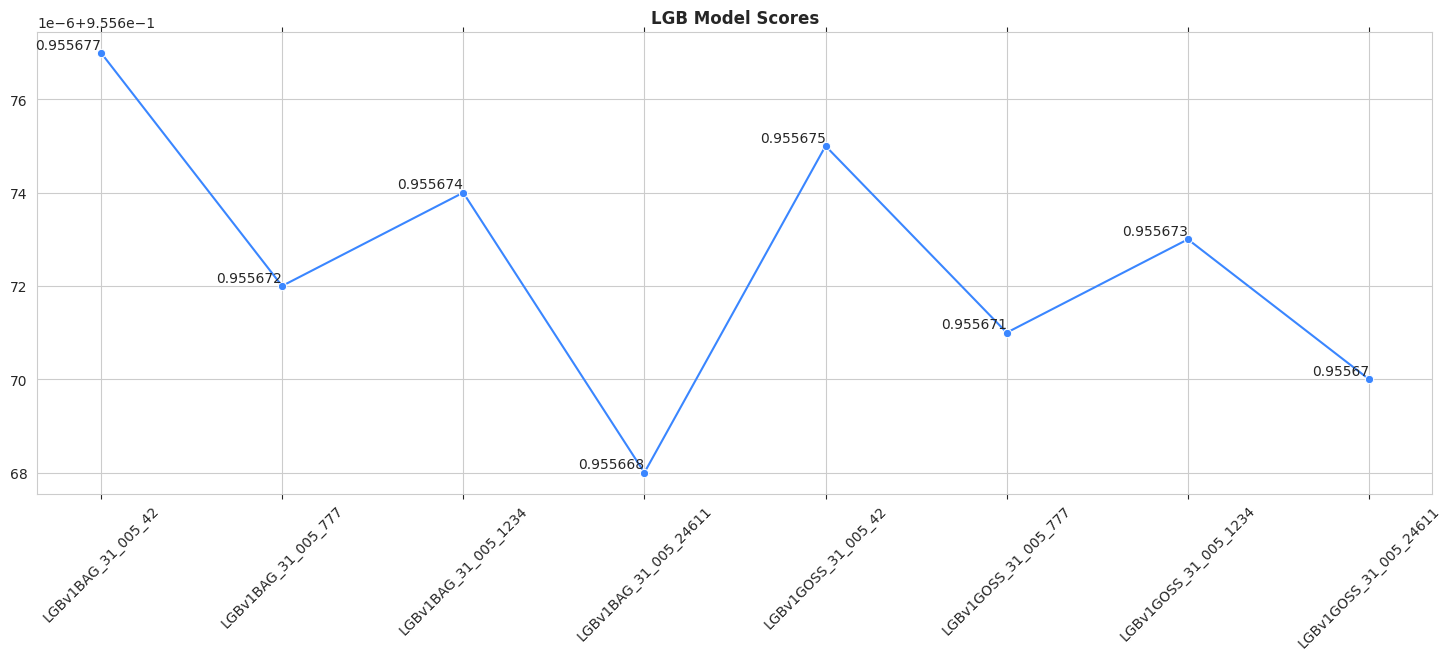

In [34]:
## -- Get Scores --
all_model_scores = {}

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            # print(k, y)
            all_model_scores[k] = y

plt.figure(figsize=(18, 6))
sns.lineplot(all_model_scores, marker='o')
# pd.Series(all_model_scores).plot(marker='o')

plt.title('LGB Model Scores', fontweight='semibold')
plt.tick_params('x', rotation=45, reset=True)

for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+2e-7, score, ha='right', va='center_baseline')

plt.show()

In [35]:
## -- Get oof outputs --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

,LGBv1BAG_31_005_42_955677,LGBv1BAG_31_005_777_955672,LGBv1BAG_31_005_1234_955674,LGBv1BAG_31_005_24611_955668,LGBv1GOSS_31_005_42_955675,LGBv1GOSS_31_005_777_955671,LGBv1GOSS_31_005_1234_955673,LGBv1GOSS_31_005_24611_95567
0,0.996346,0.996481,0.996442,0.996632,0.996300,0.996630,0.996684,0.996454
1,0.011801,0.011762,0.011885,0.011936,0.012030,0.011798,0.011733,0.011989
2,0.010784,0.010529,0.010830,0.010965,0.011021,0.010501,0.010593,0.010841
3,0.043873,0.045887,0.043688,0.043845,0.044048,0.046204,0.043252,0.043814
4,0.996969,0.997295,0.997034,0.997358,0.997009,0.997435,0.997112,0.997401


In [36]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

,LGBv1BAG_31_005_42_955677,LGBv1BAG_31_005_777_955672,LGBv1BAG_31_005_1234_955674,LGBv1BAG_31_005_24611_955668,LGBv1GOSS_31_005_42_955675,LGBv1GOSS_31_005_777_955671,LGBv1GOSS_31_005_1234_955673,LGBv1GOSS_31_005_24611_95567
0,0.953561,0.954959,0.953434,0.953535,0.953509,0.955099,0.953605,0.952829
1,0.009912,0.009809,0.009892,0.010061,0.009858,0.009879,0.009838,0.009956
2,0.988677,0.988424,0.988492,0.988366,0.988686,0.988559,0.988475,0.988340
3,0.005231,0.005060,0.005160,0.005086,0.005232,0.005110,0.005136,0.005106
4,0.183829,0.185230,0.182322,0.183502,0.184360,0.185347,0.183992,0.184976


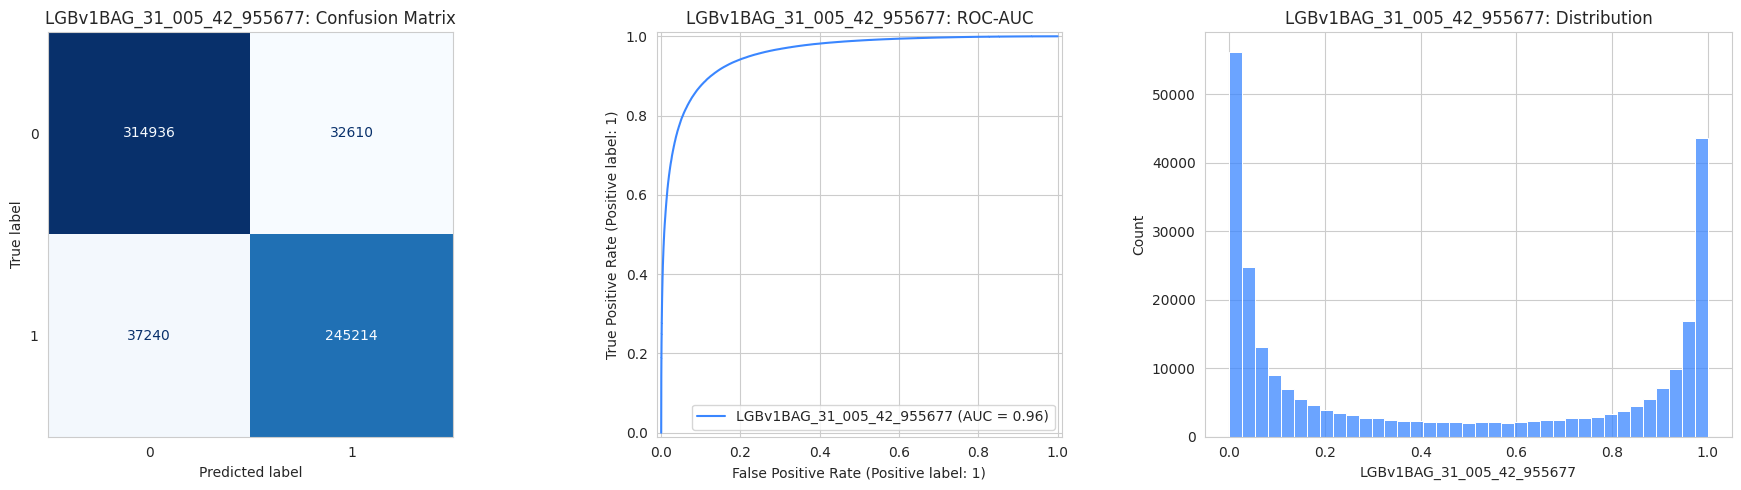

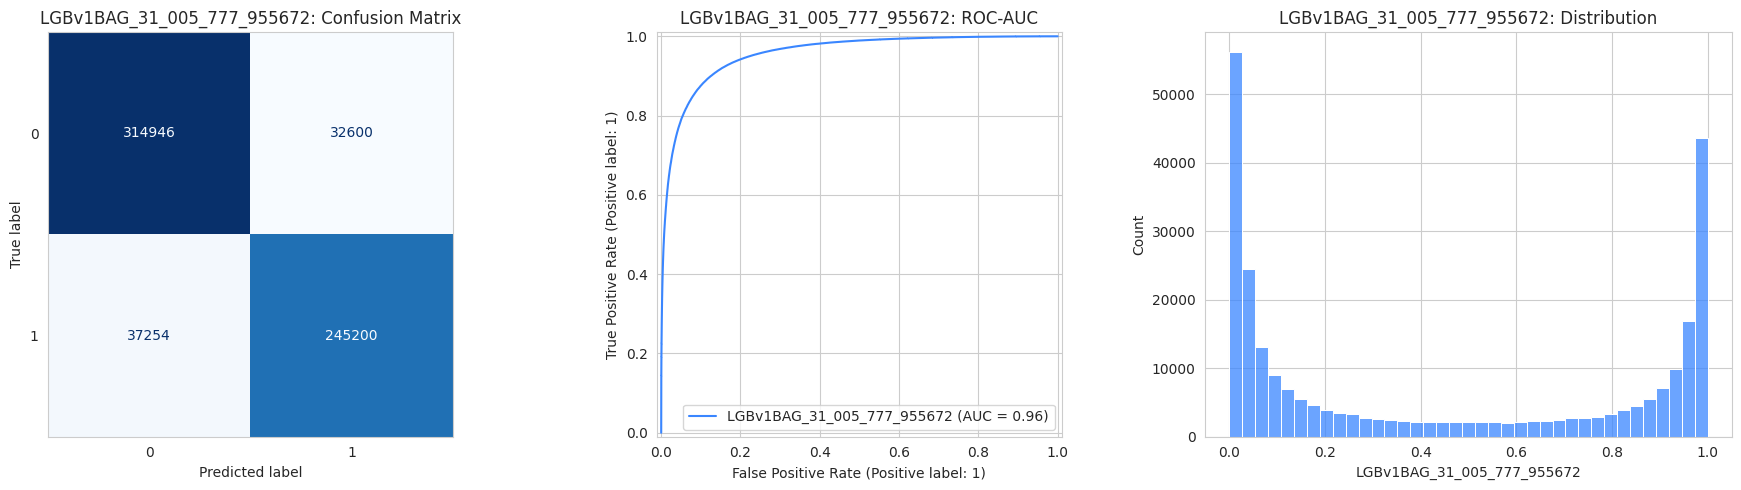

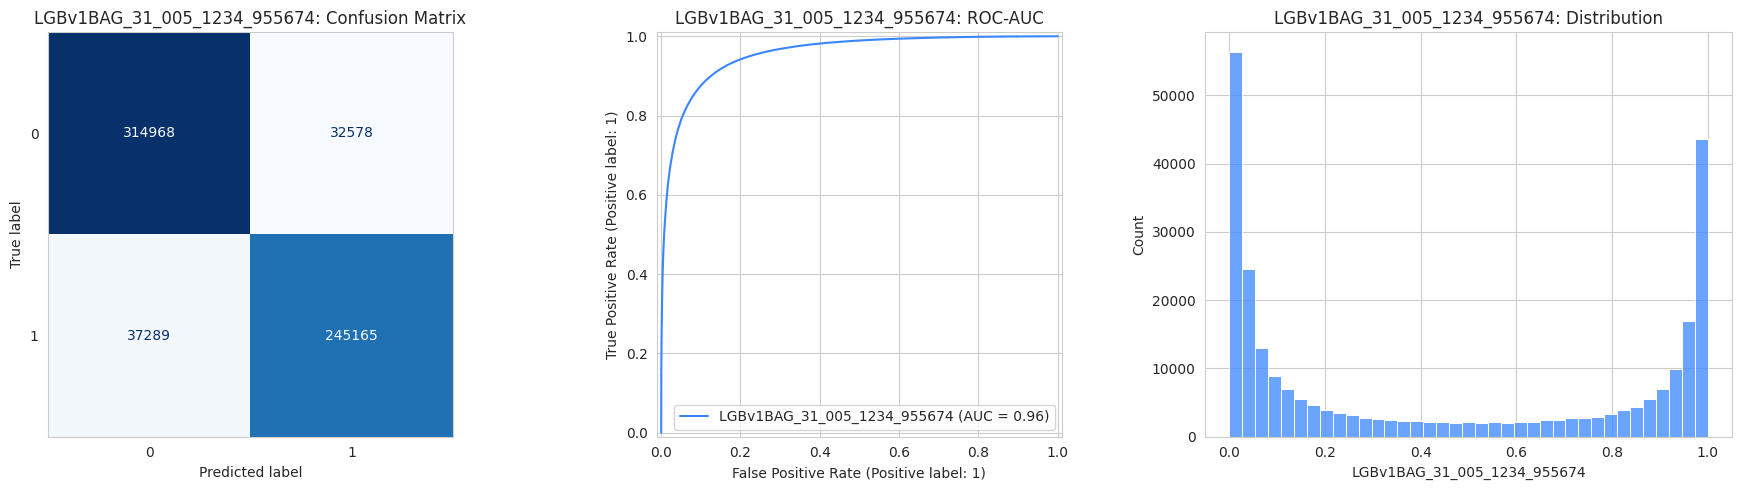

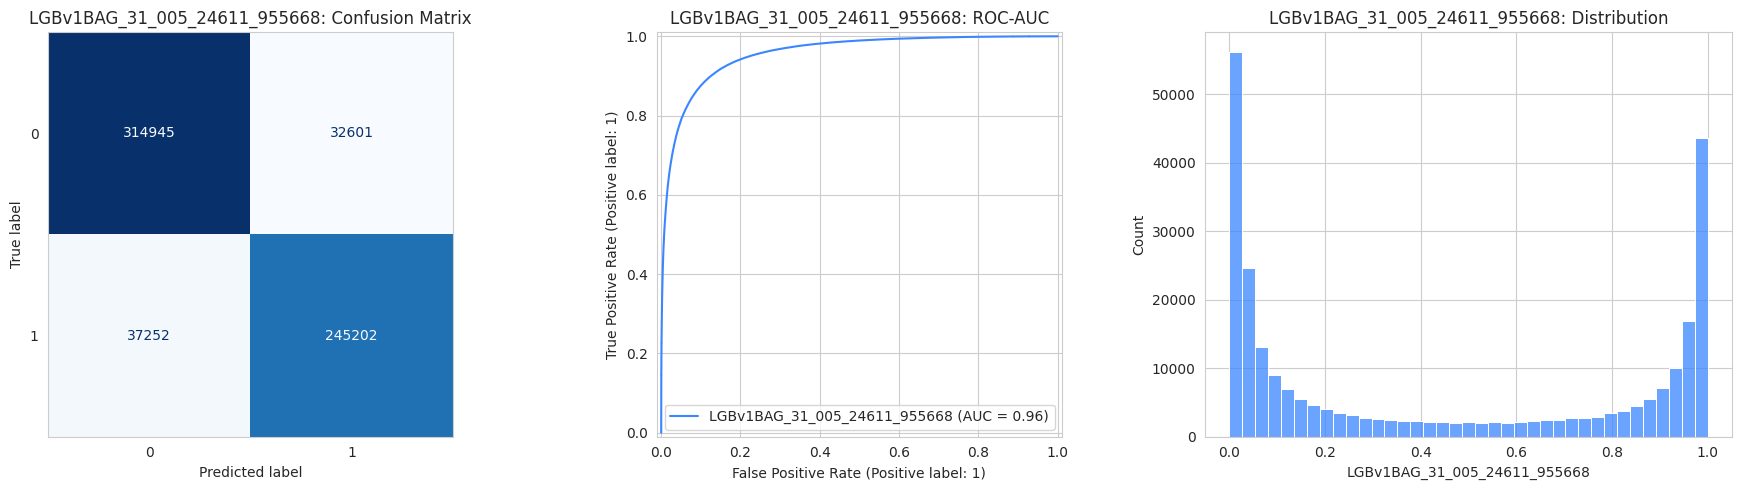

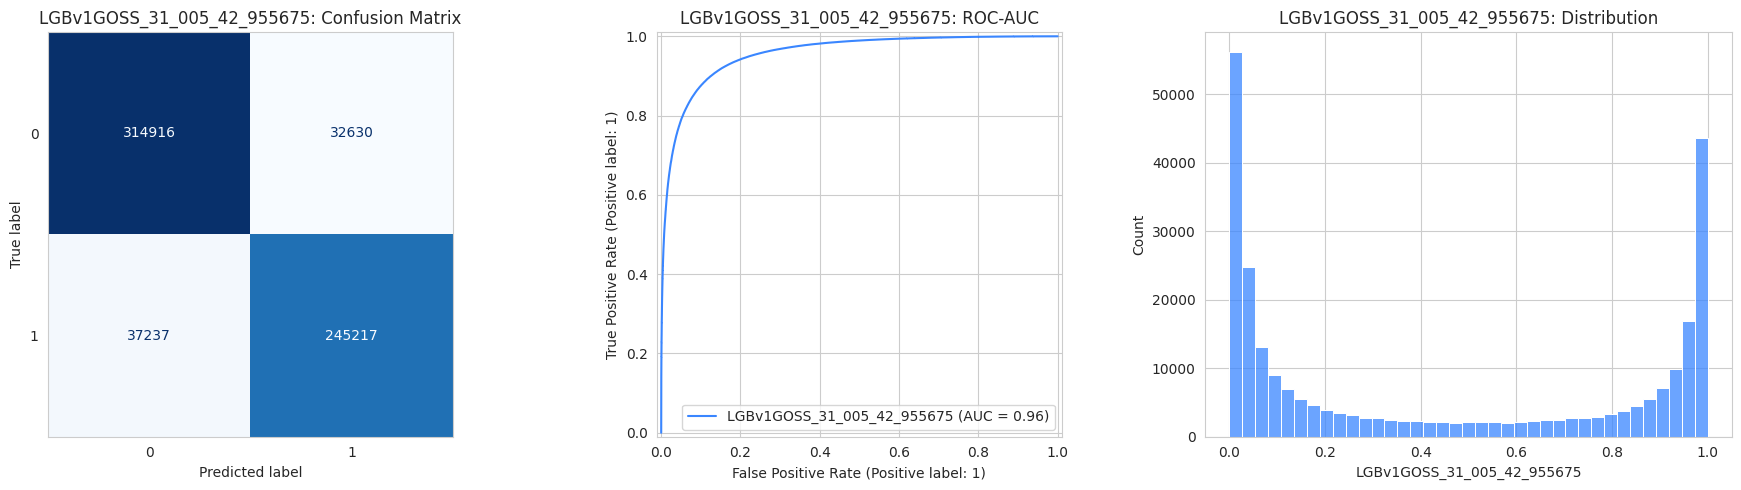

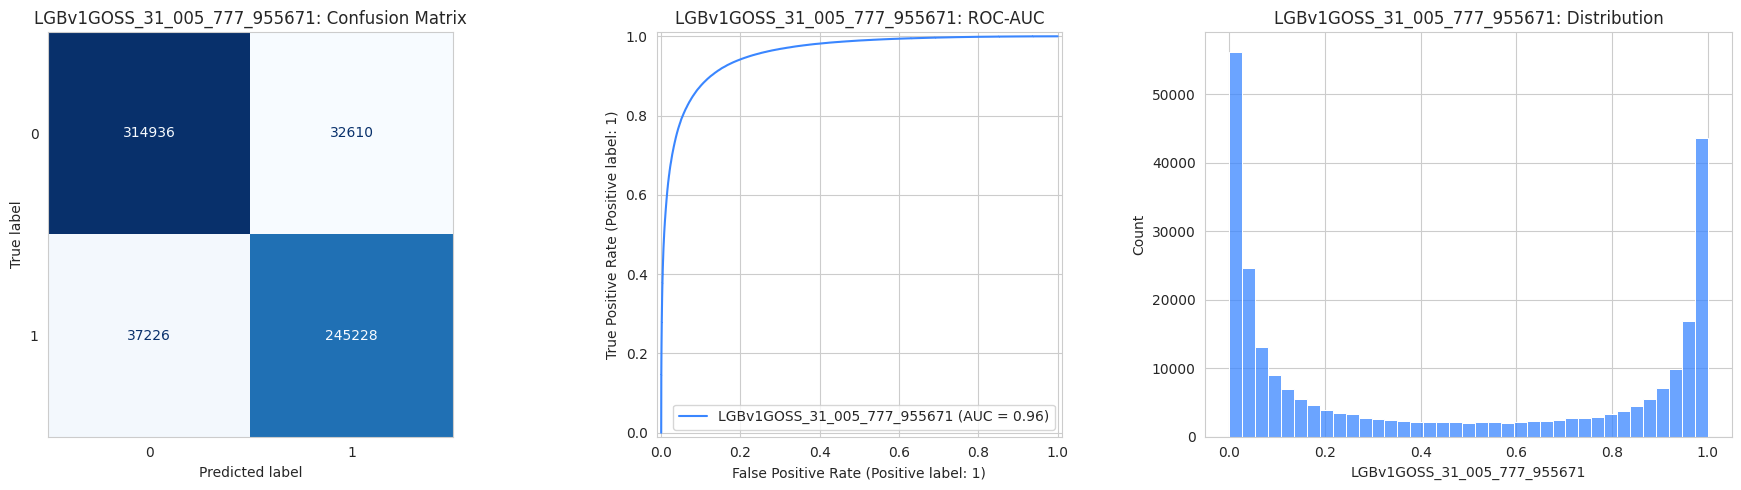

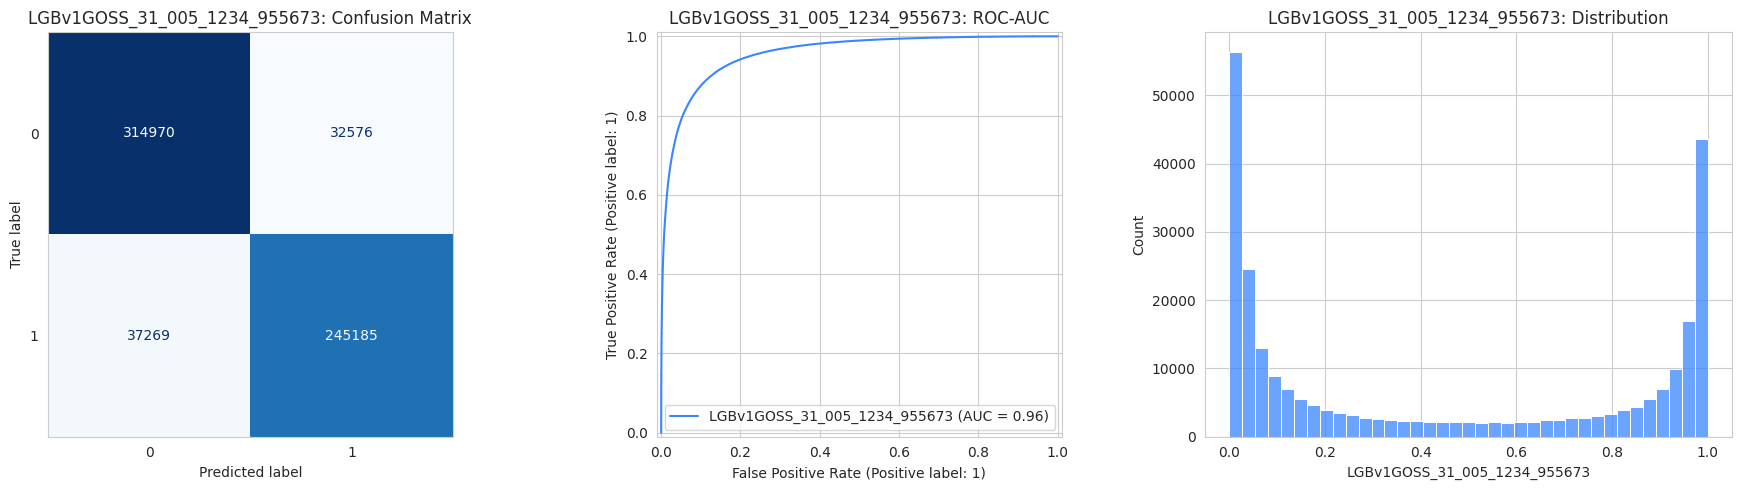

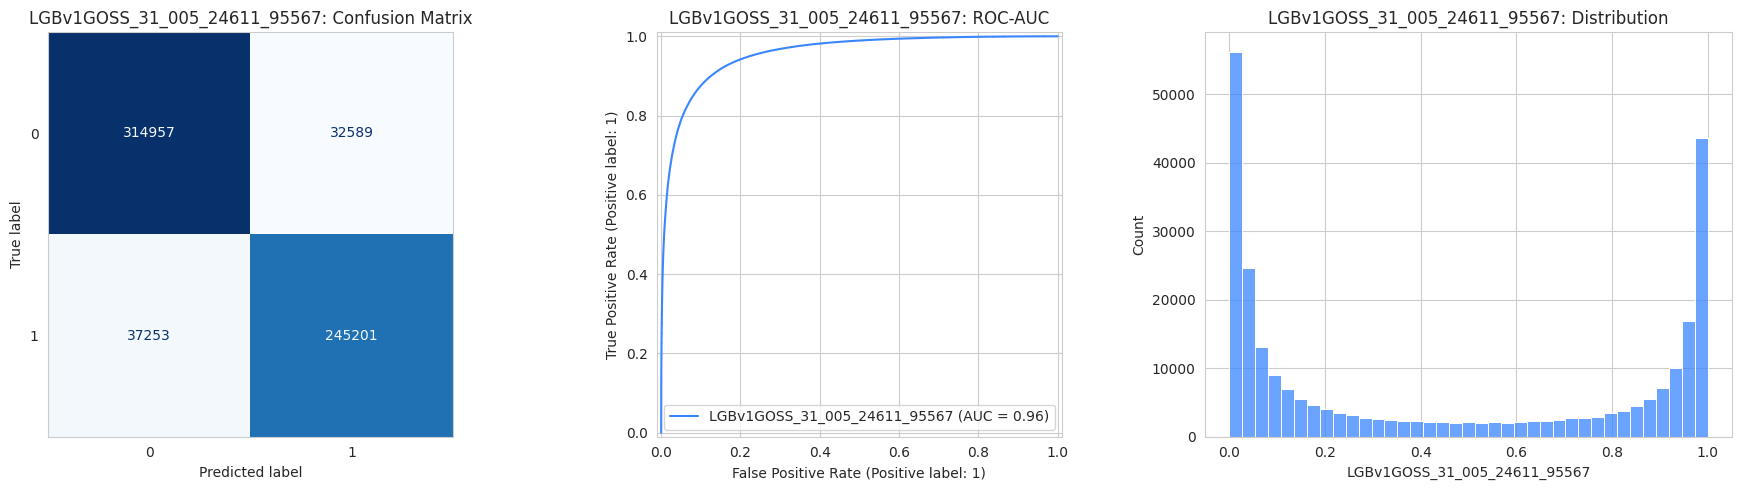

In [37]:
## -- Plot predictions --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (all_model_oof[n] >= 0.5).astype('int8')
    ConfusionMatrixDisplay.from_predictions(train[TARGET], pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    axs[0].set_title(f"{n}: Confusion Matrix")
    axs[0].grid(False)
    
    # Left: ROC curve
    # score = [x for x in all_model_scores.values()][i]
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")
    
    plt.tight_layout()
    plt.show()
    print()

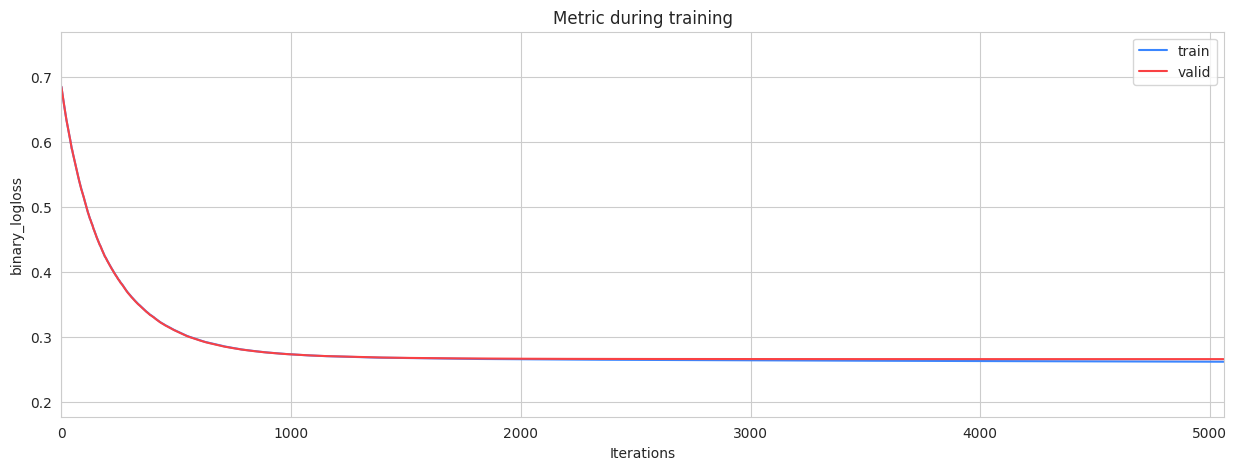

In [38]:
## -- Use any model of choice from keys... 0, 1, 2...
get_model = all_model_predictions[list(all_model_predictions.keys())[0]]

lgb.plot_metric(get_model['records'][0], figsize=(15, 5))
plt.show()

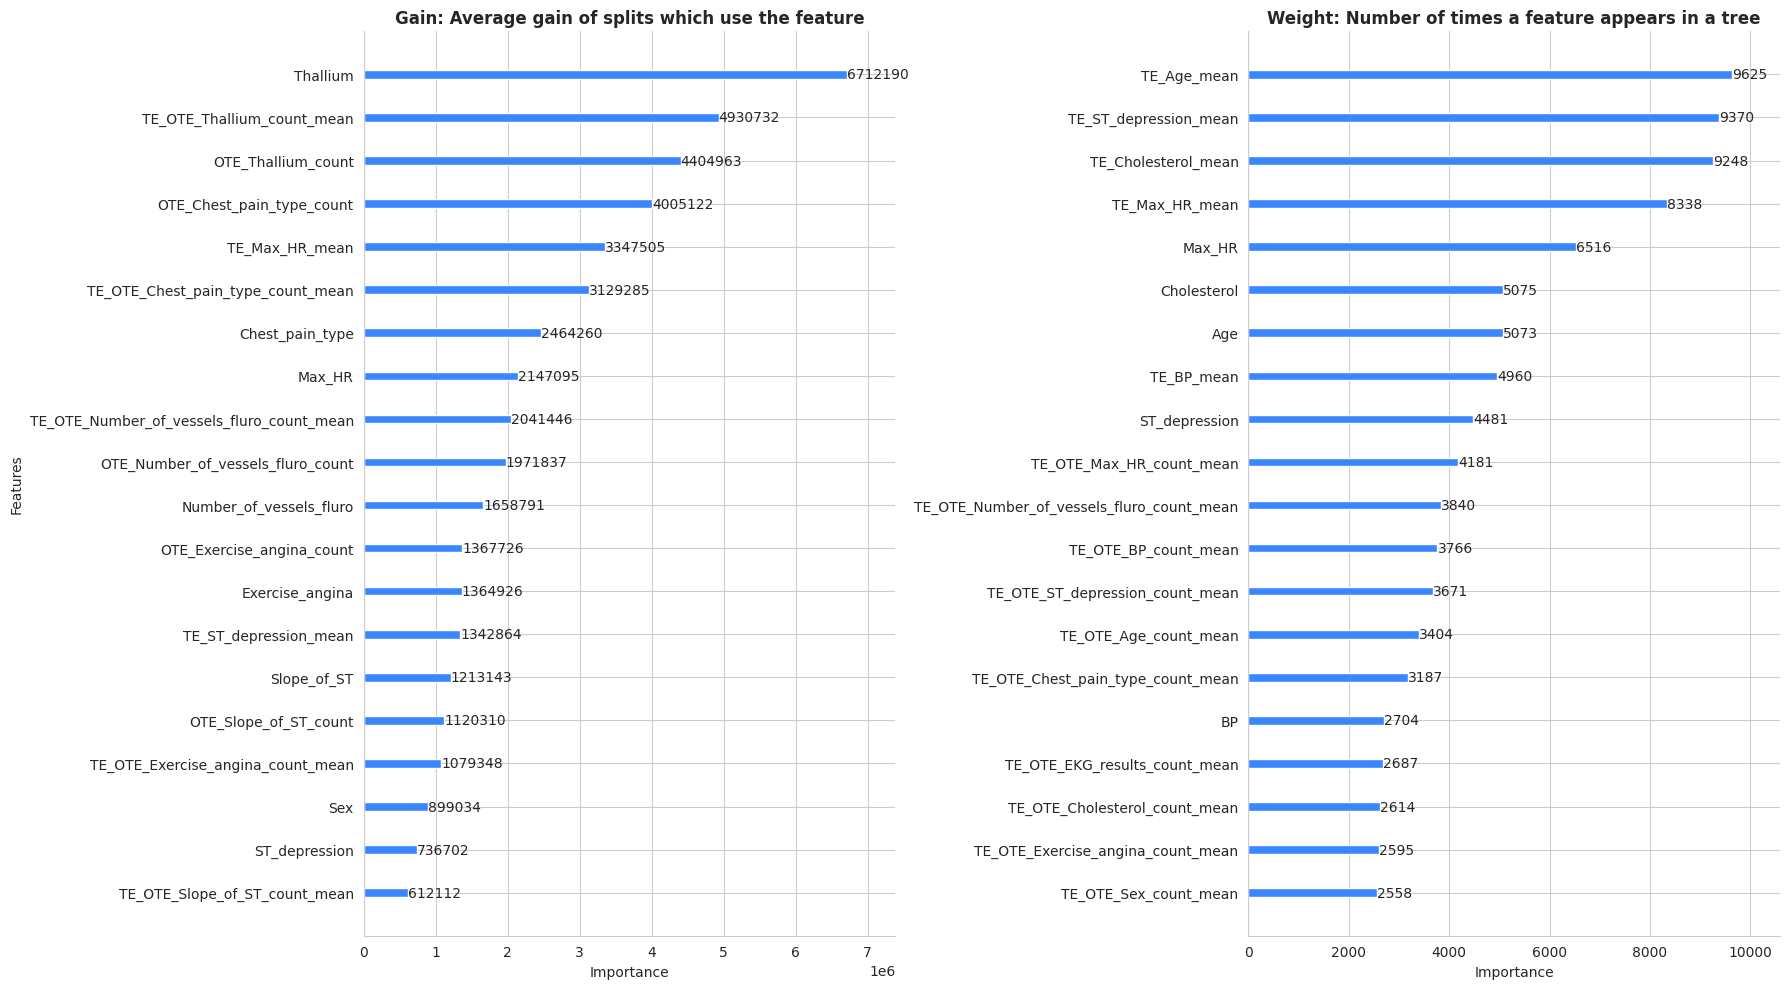

In [39]:
## -- Plot Feature Importances --
MAX = 20
_, axs = plt.subplots(1, 2, figsize=(18, 10))
lgb.plot_importance(
    get_model['model'],
    importance_type='gain',
    max_num_features=MAX,
    precision=0, ax=axs[0], # grid=False,
    # title="Gain: Total gains of splits which use the feature."
)
axs[0].set_title('Gain: Average gain of splits which use the feature', fontweight='semibold')

lgb.plot_importance(
    get_model['model'],
    importance_type='split',
    max_num_features=MAX,
    precision=0, ax=axs[1], # grid=False,
    # title="Split: Number of times the feature is used in a model."
)
axs[1].set_title('Weight: Number of times a feature appears in a tree', fontweight='semibold')
axs[1].set_ylabel('')
                 
for ax in axs:
    ax.set_xlabel('Importance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()